<a target="_blank" href="https://colab.research.google.com/github/sonder-art/bandit_simulator/blob/main/markov_bandit_sim.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import random
from typing import Tuple, List, Dict, Callable, Optional, Union
import time

# Set seeds for reproducibility
np.random.seed(None)  # Use system entropy for true randomness
random.seed(None)  # Use system entropy for true randomness

# ================ MARKOV BANDIT ENVIRONMENT CLASSES ================

class MarkovBanditEnvironment:
    """Base class for two-armed Markov bandit environments."""
    
    def __init__(self, T: int = 100, exploration_bonus: float = 0.1):
        """
        Initialize the Markov bandit environment.
        
        Args:
            T (int): Number of turns in the game
            exploration_bonus (float): Coefficient for exploration bonus
        """
        self.T = T
        self.current_turn = 0
        self.exploration_bonus = exploration_bonus
        self.states = None  # Hidden states (X_t^1, X_t^2)
        self.history = {
            'actions': [],
            'rewards': [],
            'states': [],
            'exploration_bonus': []
        }
    
    def reset(self, T: Optional[int] = None) -> None:
        """
        Reset the environment for a new game.
        
        Args:
            T (int, optional): Number of turns for the new game
        """
        if T is not None:
            self.T = T
        self.current_turn = 0
        self.history = {
            'actions': [],
            'rewards': [],
            'states': [],
            'exploration_bonus': []
        }
        self._initialize_states()
    
    def _initialize_states(self) -> None:
        """Initialize the hidden states for both arms."""
        raise NotImplementedError("Subclasses must implement this method")
    
    def _update_states(self, action: int) -> None:
        """
        Update the hidden states based on the current states and action.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        """
        raise NotImplementedError("Subclasses must implement this method")
    
    def _compute_reward(self, action: int) -> float:
        """
        Compute the reward based on the current state of the chosen arm.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        
        Returns:
            float: The reward obtained
        """
        raise NotImplementedError("Subclasses must implement this method")
    
    def _compute_exploration_bonus(self, action: int) -> float:
        """
        Compute the exploration bonus for the chosen action.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        
        Returns:
            float: The exploration bonus
        """
        # Default implementation (to be overridden by subclasses if needed)
        # Simple count-based bonus that decreases with the number of times the arm has been pulled
        action_counts = [self.history['actions'].count(0), self.history['actions'].count(1)]
        if action_counts[action] == 0:
            return self.exploration_bonus
        return self.exploration_bonus / np.sqrt(action_counts[action])
    
    def step(self, action: int) -> Tuple[float, float]:
        """
        Take a step in the environment by selecting an arm.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        
        Returns:
            Tuple[float, float]: The reward and exploration bonus obtained
        """
        # Check if the episode has ended (considering random horizon if applicable)
        if hasattr(self, 'random_horizon') and self.random_horizon:
            if hasattr(self, 'actual_horizon') and self.current_turn >= self.actual_horizon:
                raise ValueError("Game is over, please reset.")
        elif self.current_turn >= self.T:
            raise ValueError("Game is over, please reset.")
        
        # Record current state
        self.history['states'].append(self.states.copy())
        
        # Determine reward based on action and current state
        reward = self._compute_reward(action)
        
        # Compute exploration bonus
        exploration_bonus = self._compute_exploration_bonus(action)
        
        # Update history
        self.history['actions'].append(action)
        self.history['rewards'].append(reward)
        self.history['exploration_bonus'].append(exploration_bonus)
        
        # Update states based on action
        self._update_states(action)
        
        # Increment turn
        self.current_turn += 1
        
        return reward, exploration_bonus
    
    def get_visible_info(self) -> Dict:
        """
        Get the visible information for the agent.
        
        Returns:
            Dict: Dictionary with visible information
        """
        # By default, agents only see rewards, actions, turn info, and exploration bonus
        return {
            'current_turn': self.current_turn,
            'total_turns': self.T,
            'history': {
                'actions': self.history['actions'],
                'rewards': self.history['rewards'],
                'exploration_bonus': self.history['exploration_bonus']
            }
        }


class Problem1Environment(MarkovBanditEnvironment):
    """
    Problem 1: Independent, Known Transitions, Fixed T, Hidden State + Exploration Bonus
    
    Each arm follows an independent Markov process with known transition matrices.
    The states are hidden from the agent, but the transition matrices are known.
    """
    
    def __init__(self, T: int = 100, exploration_bonus: float = 0.1, 
                 state_count: int = 2, state_rewards: Optional[List[float]] = None):
        """
        Initialize Problem 1 environment.
        
        Args:
            T (int): Number of turns
            exploration_bonus (float): Coefficient for exploration bonus
            state_count (int): Number of possible states for each arm
            state_rewards (List[float], optional): Rewards for each state
        """
        super().__init__(T, exploration_bonus)
        self.state_count = state_count
        self.random_horizon = False
        
        # Generate more contrasting reward values for states
        if state_rewards is None:
            # Create more contrasting rewards between good and bad states
            base_low = 0.05 + np.random.random() * 0.2  # Low reward between 0.05-0.25
            base_high = 0.75 + np.random.random() * 0.2  # High reward between 0.75-0.95
            self.state_rewards = [base_low, base_high]
        else:
            self.state_rewards = state_rewards
        
        # Generate transition matrices for both arms
        self.transition_matrices = [
            self._generate_interesting_transition_matrix(state_count, arm_idx=i) for i in range(2)
        ]
    
    def _generate_interesting_transition_matrix(self, state_count: int, arm_idx: int) -> np.ndarray:
        """
        Generate an interesting transition matrix with specific patterns.
        
        Args:
            state_count (int): Number of states
            arm_idx (int): Index of the arm (0 or 1) to generate different patterns
        
        Returns:
            np.ndarray: Transition matrix of shape (state_count, state_count)
        """
        matrix = np.zeros((state_count, state_count))
        
        # Different patterns for different arms to create strategic diversity
        if arm_idx == 0:
            # First arm has "sticky" good state but unstable bad state
            # Good state (high index) tends to stay in good state
            # Bad state (low index) has higher chance to transition
            for i in range(state_count):
                # Higher state index = "better" state
                if i == state_count - 1:  # Good state is sticky
                    stay_prob = 0.7 + np.random.random() * 0.2  # 0.7-0.9 probability to stay
                    matrix[i, i] = stay_prob
                    # Distribute remaining probability
                    remaining = 1.0 - stay_prob
                    for j in range(state_count - 1):
                        matrix[i, j] = remaining / (state_count - 1)
                else:  # Bad states are less sticky
                    stay_prob = 0.3 + np.random.random() * 0.2  # 0.3-0.5 probability to stay
                    matrix[i, i] = stay_prob
                    # Higher chance to go to better states
                    remaining = 1.0 - stay_prob
                    better_states_prob = remaining * 0.7  # 70% of remaining goes to better states
                    better_states_count = state_count - i - 1
                    
                    if better_states_count > 0:
                        for j in range(i + 1, state_count):
                            matrix[i, j] = better_states_prob / better_states_count
                    
                    # Rest goes to worse states
                    worse_states_prob = remaining * 0.3
                    worse_states_count = i
                    
                    if worse_states_count > 0:
                        for j in range(i):
                            matrix[i, j] = worse_states_prob / worse_states_count
        else:
            # Second arm has more volatile transitions overall
            # Creates a cyclical pattern with bias towards progression
            for i in range(state_count):
                # Cyclical pattern with forward bias
                forward_idx = (i + 1) % state_count
                backward_idx = (i - 1) % state_count
                
                # Forward probability higher than backward
                forward_prob = 0.4 + np.random.random() * 0.2  # 0.4-0.6
                backward_prob = 0.1 + np.random.random() * 0.2  # 0.1-0.3
                stay_prob = 1.0 - forward_prob - backward_prob
                
                matrix[i, i] = stay_prob
                matrix[i, forward_idx] = forward_prob
                matrix[i, backward_idx] = backward_prob
        
        # Normalize rows to ensure they sum to 1
        for i in range(state_count):
            row_sum = np.sum(matrix[i])
            if row_sum > 0:
                matrix[i] = matrix[i] / row_sum
        
        return matrix
    
    def _initialize_states(self) -> None:
        """Initialize the hidden states for both arms."""
        # Randomly initialize the state for each arm
        self.states = [
            np.random.randint(0, self.state_count) for _ in range(2)
        ]
    
    def _joint_state_to_individual(self, joint_state: int) -> List[int]:
        """
        Convert a joint state index to individual arm states.
        
        Args:
            joint_state (int): Joint state index
        
        Returns:
            List[int]: Individual states [state1, state2]
        """
        state1 = joint_state // self.state_count
        state2 = joint_state % self.state_count
        return [state1, state2]
    
    def _individual_to_joint_state(self, states: List[int]) -> int:
        """
        Convert individual arm states to a joint state index.
        
        Args:
            states (List[int]): Individual states [state1, state2]
        
        Returns:
            int: Joint state index
        """
        return states[0] * self.state_count + states[1]
    
    def _update_states(self, action: int) -> None:
        """
        Update the hidden states based on the current states and the transition matrices.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        """
        if self.joint_dynamics:
            # Convert individual states to joint state
            current_joint_state = self._individual_to_joint_state(self.states)
            
            # Get transition probabilities for the current joint state
            transition_probabilities = self.joint_transition_matrix[current_joint_state]
            
            # Sample next joint state
            next_joint_state = np.random.choice(self.joint_state_count, p=transition_probabilities)
            
            # Convert back to individual states
            self.states = self._joint_state_to_individual(next_joint_state)
        else:
            # Update each arm's state independently
            for arm in range(2):
                current_state = self.states[arm]
                transition_probabilities = self.transition_matrices[arm][current_state]
                self.states[arm] = np.random.choice(self.state_count, p=transition_probabilities)
    
    def _compute_reward(self, action: int) -> float:
        """
        Compute the reward based on the current state of the chosen arm.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        
        Returns:
            float: The reward obtained
        """
        # Get the current state of the chosen arm
        current_state = self.states[action]
        
        # The reward is Bernoulli with probability depending on the state
        reward_probability = self.state_rewards[current_state]
        return 1.0 if np.random.random() < reward_probability else 0.0
    
    def get_visible_info(self) -> Dict:
        """
        Get the visible information for the agent.
        
        Returns:
            Dict: Dictionary with visible information
        """
        info = super().get_visible_info()
        
        # Add transition information if known
        if self.known_transitions:
            if self.joint_dynamics:
                info['joint_transition_matrix'] = self.joint_transition_matrix
                info['joint_dynamics'] = True
            else:
                info['transition_matrices'] = self.transition_matrices
                info['joint_dynamics'] = False
            
            info['state_rewards'] = self.state_rewards
        
        # If horizon is random, don't provide the actual horizon
        if self.random_horizon:
            info['random_horizon'] = True
            info['discount_factor'] = self.discount_factor
            # Remove total_turns since it's unknown
            info.pop('total_turns', None)
        
        return info
    
    def step(self, action: int) -> Tuple[float, float]:
        """
        Take a step in the environment by selecting an arm.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        
        Returns:
            Tuple[float, float]: The reward and exploration bonus obtained
        """
        # Check if the episode has ended (for random horizon)
        if self.random_horizon:
            if self.current_turn >= self.actual_horizon:
                raise ValueError("Game is over, please reset.")
        else:
            if self.current_turn >= self.T:
                raise ValueError("Game is over, please reset.")
        
        # Use the parent's step method
        return super().step(action)
    
    def _initialize_states(self) -> None:
        """Initialize the hidden states for both arms."""
        # Randomly initialize the state for each arm
        self.states = [
            np.random.randint(0, self.state_count) for _ in range(2)
        ]
    
    def _update_states(self, action: int) -> None:
        """
        Update the hidden states based on the current states and the known transition matrices.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        """
        # Update each arm's state independently according to its transition matrix
        for arm in range(2):
            current_state = self.states[arm]
            transition_probabilities = self.transition_matrices[arm][current_state]
            self.states[arm] = np.random.choice(self.state_count, p=transition_probabilities)
    
    def _compute_reward(self, action: int) -> float:
        """
        Compute the reward based on the current state of the chosen arm.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        
        Returns:
            float: The reward obtained
        """
        # Get the current state of the chosen arm
        current_state = self.states[action]
        
        # The reward is Bernoulli with probability depending on the state
        reward_probability = self.state_rewards[current_state]
        return 1.0 if np.random.random() < reward_probability else 0.0
    
    def get_visible_info(self) -> Dict:
        """
        Get the visible information for the agent.
        
        Returns:
            Dict: Dictionary with visible information including known transition matrices
        """
        info = super().get_visible_info()
        info['transition_matrices'] = self.transition_matrices
        info['state_rewards'] = self.state_rewards
        return info


class Problem2Environment(MarkovBanditEnvironment):
    """
    Problem 2: Independent, Unknown Transitions, Fixed T, Hidden State + Exploration Bonus
    
    Each arm follows an independent Markov process with unknown transition matrices.
    The states are hidden from the agent, and the transition matrices are unknown.
    """
    
    def __init__(self, T: int = 100, exploration_bonus: float = 0.1, 
                 state_count: int = 2, state_rewards: Optional[List[float]] = None):
        """
        Initialize Problem 2 environment.
        
        Args:
            T (int): Number of turns
            exploration_bonus (float): Coefficient for exploration bonus
            state_count (int): Number of possible states for each arm
            state_rewards (List[float], optional): Rewards for each state
        """
        super().__init__(T, exploration_bonus)
        self.state_count = state_count
        self.random_horizon = False
        
        # Generate more contrasting reward values for states
        if state_rewards is None:
            # Create more contrasting rewards between good and bad states
            base_low = 0.05 + np.random.random() * 0.15  # Low reward between 0.05-0.2
            base_high = 0.8 + np.random.random() * 0.15  # High reward between 0.8-0.95
            self.state_rewards = [base_low, base_high]
        else:
            self.state_rewards = state_rewards
        
        # Generate transition matrices for both arms (unknown to the agent)
        self.transition_matrices = [
            self._generate_interesting_transition_matrix(state_count, arm_idx=i) for i in range(2)
        ]
    
    def _generate_interesting_transition_matrix(self, state_count: int, arm_idx: int) -> np.ndarray:
        """
        Generate an interesting transition matrix with specific patterns.
        
        Args:
            state_count (int): Number of states
            arm_idx (int): Index of the arm (0 or 1) to generate different patterns
        
        Returns:
            np.ndarray: Transition matrix of shape (state_count, state_count)
        """
        matrix = np.zeros((state_count, state_count))
        
        # Pattern type determined by arm index to create different strategic challenges
        if arm_idx == 0:
            # First arm has a tendency to deteriorate over time
            # Higher probability to move to worse states from good states
            for i in range(state_count):
                # Base probability to stay in current state
                stay_prob = 0.3 + np.random.random() * 0.3  # 0.3-0.6
                matrix[i, i] = stay_prob
                
                remaining = 1.0 - stay_prob
                
                # Calculate transition probabilities based on current state
                if i < state_count - 1:  # Not the worst state
                    # Probability to move to worse states increases with state quality
                    worse_bias = 0.3 + (i / (state_count - 1)) * 0.5  # 0.3-0.8 based on state
                    better_bias = 1.0 - worse_bias
                    
                    # Calculate number of worse and better states
                    worse_states = i
                    better_states = state_count - i - 1
                    
                    # Distribute probabilities
                    if worse_states > 0:
                        worse_prob = remaining * worse_bias
                        for j in range(worse_states):
                            matrix[i, j] = worse_prob / worse_states
                    
                    if better_states > 0:
                        better_prob = remaining * better_bias
                        for j in range(i + 1, state_count):
                            matrix[i, j] = better_prob / better_states
                else:  # Worst state
                    # From worst state, can only go to better states
                    for j in range(i):
                        matrix[i, j] = remaining / i
        else:
            # Second arm has alternating pattern - tends to swing between extremes
            for i in range(state_count):
                # Probability to stay
                stay_prob = 0.2 + np.random.random() * 0.3  # 0.2-0.5
                matrix[i, i] = stay_prob
                
                remaining = 1.0 - stay_prob
                
                # Find the most distant state
                distant_idx = (i + state_count // 2) % state_count
                
                # Higher probability to jump to distant state
                distant_prob = remaining * (0.6 + np.random.random() * 0.2)  # 60-80% of remaining
                matrix[i, distant_idx] = distant_prob
                
                # Distribute remaining probability to other states
                other_remaining = remaining - distant_prob
                other_states = state_count - 2  # excluding current and distant
                
                if other_states > 0:
                    for j in range(state_count):
                        if j != i and j != distant_idx:
                            matrix[i, j] = other_remaining / other_states
        
        # Normalize rows to ensure they sum to 1
        for i in range(state_count):
            row_sum = np.sum(matrix[i])
            if row_sum > 0:
                matrix[i] = matrix[i] / row_sum
        
        return matrix
    
    def _initialize_states(self) -> None:
        """Initialize the hidden states for both arms."""
        # Randomly initialize the state for each arm
        self.states = [
            np.random.randint(0, self.state_count) for _ in range(2)
        ]
    
    def _update_states(self, action: int) -> None:
        """
        Update the hidden states based on the current states and the transition matrices.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        """
        # Update each arm's state independently according to its transition matrix
        for arm in range(2):
            current_state = self.states[arm]
            transition_probabilities = self.transition_matrices[arm][current_state]
            self.states[arm] = np.random.choice(self.state_count, p=transition_probabilities)
    
    def _compute_reward(self, action: int) -> float:
        """
        Compute the reward based on the current state of the chosen arm.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        
        Returns:
            float: The reward obtained
        """
        # Get the current state of the chosen arm
        current_state = self.states[action]
        
        # The reward is Bernoulli with probability depending on the state
        reward_probability = self.state_rewards[current_state]
        return 1.0 if np.random.random() < reward_probability else 0.0
    
    def get_visible_info(self) -> Dict:
        """
        Get the visible information for the agent.
        
        Returns:
            Dict: Dictionary with visible information (transitions are unknown to the agent)
        """
        # Same as base class, no transition information is provided
        return super().get_visible_info()


class Problem3Environment(MarkovBanditEnvironment):
    """
    Problem 3: Dependent (Joint), Known Transitions, Fixed T, Hidden State + Exploration Bonus
    
    Both arms follow a joint Markov process with known transition matrix.
    The states are hidden from the agent, but the joint transition matrix is known.
    """
    
    def __init__(self, T: int = 100, exploration_bonus: float = 0.1, 
                 state_count: int = 2, state_rewards: Optional[List[float]] = None):
        """
        Initialize Problem 3 environment.
        
        Args:
            T (int): Number of turns
            exploration_bonus (float): Coefficient for exploration bonus
            state_count (int): Number of possible states for each arm
            state_rewards (List[float], optional): Rewards for each state
        """
        super().__init__(T, exploration_bonus)
        self.state_count = state_count
        self.random_horizon = False
        
        # Generate more contrasting reward values for states
        if state_rewards is None:
            # Create more contrasting rewards between good and bad states
            base_low = 0.1 + np.random.random() * 0.15  # Low reward between 0.1-0.25
            base_high = 0.8 + np.random.random() * 0.15  # High reward between 0.8-0.95
            self.state_rewards = [base_low, base_high]
        else:
            self.state_rewards = state_rewards
        
        # Total number of joint states (state_count^2)
        self.joint_state_count = state_count ** 2
        
        # Generate joint transition matrix with interesting patterns
        self.joint_transition_matrix = self._generate_interesting_joint_transition_matrix()
    
    def _generate_interesting_joint_transition_matrix(self) -> np.ndarray:
        """
        Generate an interesting joint transition matrix with specific dependency patterns.
        
        Returns:
            np.ndarray: Joint transition matrix of shape (joint_state_count, joint_state_count)
        """
        matrix = np.zeros((self.joint_state_count, self.joint_state_count))
        
        # Create joint state transition patterns that show interesting dependencies
        for i in range(self.joint_state_count):
            # Convert joint state to individual states
            state1, state2 = self._joint_state_to_individual(i)
            
            # Base probability to stay in current state
            stay_prob = 0.2 + np.random.random() * 0.2  # 0.2-0.4
            matrix[i, i] = stay_prob
            
            remaining = 1.0 - stay_prob
            
            # Define transition types based on current joint state
            
            # Type 1: Opposite movement - when arms are in same state, they tend to diverge
            if state1 == state2:
                # Find opposite states where one goes up and one goes down
                opposite_states = []
                for s1 in range(self.state_count):
                    for s2 in range(self.state_count):
                        # If one state improves and one worsens
                        if (s1 > state1 and s2 < state2) or (s1 < state1 and s2 > state2):
                            opposite_states.append(self._individual_to_joint_state([s1, s2]))
                
                if opposite_states:
                    # 70% chance to move to opposite states
                    opposite_prob = remaining * 0.7
                    for j in opposite_states:
                        matrix[i, j] = opposite_prob / len(opposite_states)
                    
                    # 30% distributed to other states
                    other_prob = remaining * 0.3
                    other_count = self.joint_state_count - 1 - len(opposite_states)
                    if other_count > 0:
                        for j in range(self.joint_state_count):
                            if j != i and j not in opposite_states:
                                matrix[i, j] = other_prob / other_count
            
            # Type 2: When first arm is good and second is bad, they tend to both become good
            elif state1 > state2:
                # Calculate better states for both arms
                better_states = []
                for s1 in range(state1, self.state_count):
                    for s2 in range(state2 + 1, self.state_count):
                        better_states.append(self._individual_to_joint_state([s1, s2]))
                
                if better_states:
                    # 60% chance to improve both
                    better_prob = remaining * 0.6
                    for j in better_states:
                        matrix[i, j] = better_prob / len(better_states)
                    
                    # 40% distributed to other states
                    other_prob = remaining * 0.4
                    other_count = self.joint_state_count - 1 - len(better_states)
                    if other_count > 0:
                        for j in range(self.joint_state_count):
                            if j != i and j not in better_states:
                                matrix[i, j] = other_prob / other_count
            
            # Type 3: When second arm is good and first is bad, they tend to both become bad
            elif state1 < state2:
                # Calculate worse states for both arms
                worse_states = []
                for s1 in range(0, state1):
                    for s2 in range(0, state2):
                        worse_states.append(self._individual_to_joint_state([s1, s2]))
                
                if worse_states:
                    # 60% chance to both worsen
                    worse_prob = remaining * 0.6
                    for j in worse_states:
                        matrix[i, j] = worse_prob / len(worse_states)
                    
                    # 40% distributed to other states
                    other_prob = remaining * 0.4
                    other_count = self.joint_state_count - 1 - len(worse_states)
                    if other_count > 0:
                        for j in range(self.joint_state_count):
                            if j != i and j not in worse_states:
                                matrix[i, j] = other_prob / other_count
        
        # Normalize rows to ensure they sum to 1
        for i in range(self.joint_state_count):
            row_sum = np.sum(matrix[i])
            if row_sum > 0:
                matrix[i] = matrix[i] / row_sum
        
        return matrix
    
    def _initialize_states(self) -> None:
        """Initialize the hidden states for both arms."""
        # Randomly initialize the state for each arm
        self.states = [
            np.random.randint(0, self.state_count) for _ in range(2)
        ]
    
    def _joint_state_to_individual(self, joint_state: int) -> List[int]:
        """
        Convert a joint state index to individual arm states.
        
        Args:
            joint_state (int): Joint state index
        
        Returns:
            List[int]: Individual states [state1, state2]
        """
        state1 = joint_state // self.state_count
        state2 = joint_state % self.state_count
        return [state1, state2]
    
    def _individual_to_joint_state(self, states: List[int]) -> int:
        """
        Convert individual arm states to a joint state index.
        
        Args:
            states (List[int]): Individual states [state1, state2]
        
        Returns:
            int: Joint state index
        """
        return states[0] * self.state_count + states[1]
    
    def _update_states(self, action: int) -> None:
        """
        Update the hidden states based on the current joint state and the joint transition matrix.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        """
        # Convert individual states to joint state
        current_joint_state = self._individual_to_joint_state(self.states)
        
        # Get transition probabilities for the current joint state
        transition_probabilities = self.joint_transition_matrix[current_joint_state]
        
        # Sample next joint state
        next_joint_state = np.random.choice(self.joint_state_count, p=transition_probabilities)
        
        # Convert back to individual states
        self.states = self._joint_state_to_individual(next_joint_state)
    
    def _compute_reward(self, action: int) -> float:
        """
        Compute the reward based on the current state of the chosen arm.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        
        Returns:
            float: The reward obtained
        """
        # Get the current state of the chosen arm
        current_state = self.states[action]
        
        # The reward is Bernoulli with probability depending on the state
        reward_probability = self.state_rewards[current_state]
        return 1.0 if np.random.random() < reward_probability else 0.0
    
    def get_visible_info(self) -> Dict:
        """
        Get the visible information for the agent.
        
        Returns:
            Dict: Dictionary with visible information including known joint transition matrix
        """
        info = super().get_visible_info()
        info['joint_transition_matrix'] = self.joint_transition_matrix
        info['state_count'] = self.state_count
        info['state_rewards'] = self.state_rewards
        return info


class Problem4Environment(MarkovBanditEnvironment):
    """
    Problem 4: Partially Observable / Possibly Unknown / Possibly Random T
    
    This is the most general case: states are hidden, transitions can be known or unknown,
    and the horizon can be random or infinite.
    """
    
    def __init__(self, T: int = 100, exploration_bonus: float = 0.1, 
                 state_count: int = 2, state_rewards: Optional[List[float]] = None,
                 known_transitions: bool = False, random_horizon: bool = False,
                 joint_dynamics: bool = False, discount_factor: float = 0.95):
        """
        Initialize Problem 4 environment.
        
        Args:
            T (int): Number of turns or expected turns if random_horizon is True
            exploration_bonus (float): Coefficient for exploration bonus
            state_count (int): Number of possible states for each arm
            state_rewards (List[float], optional): Rewards for each state
            known_transitions (bool): Whether transitions are known to the agent
            random_horizon (bool): Whether the time horizon is random
            joint_dynamics (bool): Whether arms have joint dynamics or independent dynamics
            discount_factor (float): Discount factor for infinite horizon (if random_horizon is True)
        """
        super().__init__(T, exploration_bonus)
        self.state_count = state_count
        
        # Generate more contrasting reward values for states
        if state_rewards is None:
            # Create significantly different rewards for different states
            if state_count == 2:
                # For binary states, create higher contrast
                base_low = 0.05 + np.random.random() * 0.1  # Low reward between 0.05-0.15
                base_high = 0.85 + np.random.random() * 0.1  # High reward between 0.85-0.95
                self.state_rewards = [base_low, base_high]
            else:
                # For multiple states, create a progression with some randomization
                self.state_rewards = []
                for i in range(state_count):
                    # Base reward increases with state index, with some noise
                    base = 0.05 + (0.9 / (state_count - 1)) * i  # Linear progression from 0.05 to 0.95
                    noise = np.random.random() * 0.1 - 0.05  # ±0.05 noise
                    self.state_rewards.append(min(max(base + noise, 0.01), 0.99))  # Keep in [0.01, 0.99]
        else:
            self.state_rewards = state_rewards
        
        self.known_transitions = known_transitions
        self.random_horizon = random_horizon
        self.joint_dynamics = joint_dynamics
        self.discount_factor = discount_factor
        
        # Generate transition matrices with interesting patterns
        if joint_dynamics:
            self.joint_state_count = state_count ** 2
            self.joint_transition_matrix = self._generate_interesting_joint_transition_matrix()
            self.transition_matrices = None
        else:
            self.transition_matrices = [
                self._generate_interesting_transition_matrix(state_count, arm_idx=i) for i in range(2)
            ]
            self.joint_transition_matrix = None
        
        # If using a random horizon, generate the actual horizon
        if random_horizon:
            # Generate a geometric random variable with mean T
            p = 1.0 / T
            self.actual_horizon = np.random.geometric(p)
        else:
            self.actual_horizon = T
            
        # Initialize states explicitly (this is the key fix)
        self._initialize_states()
    
    def _generate_interesting_transition_matrix(self, state_count: int, arm_idx: int) -> np.ndarray:
        """
        Generate an interesting transition matrix for independent arm dynamics.
        
        Args:
            state_count (int): Number of states
            arm_idx (int): Index of the arm (0 or 1) to generate different patterns
        
        Returns:
            np.ndarray: Transition matrix of shape (state_count, state_count)
        """
        matrix = np.zeros((state_count, state_count))
        
        # Create different transition patterns based on arm index
        if arm_idx == 0:
            # First arm has more predictable, structured transitions
            # Higher probability to move in specific directions based on state
            for i in range(state_count):
                # Probability to stay in current state
                position_factor = i / max(1, state_count - 1)  # 0 to 1 based on position
                
                # Better states are more stable, worse states less stable
                stay_prob = 0.2 + position_factor * 0.5  # 0.2-0.7 based on state quality
                matrix[i, i] = stay_prob
                
                remaining = 1.0 - stay_prob
                
                # Probability to move to better states decreases in better states
                # Better states can more easily fall to worse states
                if i < state_count - 1:  # Not in best state
                    better_prob = remaining * (0.8 - position_factor * 0.6)  # 0.8-0.2 based on state
                    better_states = state_count - i - 1
                    
                    for j in range(i + 1, state_count):
                        if better_states > 0:
                            # Higher probability to adjacent states, less to far states
                            dist_factor = 1 - (j - i - 1) / better_states
                            matrix[i, j] = better_prob * dist_factor / sum(1 - (k - i - 1) / better_states for k in range(i + 1, state_count))
                
                # Probability to move to worse states increases in better states
                if i > 0:  # Not in worst state
                    worse_prob = remaining * (0.2 + position_factor * 0.6)  # 0.2-0.8 based on state
                    worse_states = i
                    
                    for j in range(i):
                        if worse_states > 0:
                            # Higher probability to adjacent states, less to far states
                            dist_factor = 1 - (i - j - 1) / worse_states
                            matrix[i, j] = worse_prob * dist_factor / sum(1 - (i - k - 1) / worse_states for k in range(i))
        else:
            # Second arm has more volatile but cyclical pattern
            # Creates a wave-like movement pattern through states
            for i in range(state_count):
                # Lower probability to stay in any state
                stay_prob = 0.1 + np.random.random() * 0.2  # 0.1-0.3
                matrix[i, i] = stay_prob
                
                remaining = 1.0 - stay_prob
                
                # Calculate distance to other states (in a circular sense)
                distances = {}
                for j in range(state_count):
                    if j != i:
                        # Calculate circular distance (smaller of clockwise and counterclockwise)
                        clockwise = (j - i) % state_count
                        counterclockwise = (i - j) % state_count
                        distances[j] = min(clockwise, counterclockwise)
                
                # Assign higher probabilities to states at specific distances
                # Create a wave pattern where probability peaks at certain distances
                total_weight = 0
                weights = {}
                for j, distance in distances.items():
                    # Create a sinusoidal weighting based on distance
                    # Peak at distance = 1 and distance = state_count//2
                    if distance == 1:
                        weights[j] = 0.8 + np.random.random() * 0.2  # High probability to adjacent
                    elif distance == state_count // 2:
                        weights[j] = 0.5 + np.random.random() * 0.3  # Medium probability to opposite
                    else:
                        # Gradually decrease for other distances
                        weights[j] = 0.1 + (0.3 * np.sin(np.pi * distance / state_count))
                    total_weight += weights[j]
                
                # Normalize weights and assign to matrix
                for j, weight in weights.items():
                    matrix[i, j] = remaining * weight / total_weight
        
        # Normalize rows to ensure they sum to 1
        for i in range(state_count):
            row_sum = np.sum(matrix[i])
            if row_sum > 0:
                matrix[i] = matrix[i] / row_sum
        
        return matrix
    
    def _generate_interesting_joint_transition_matrix(self) -> np.ndarray:
        """
        Generate an interesting joint transition matrix with complex dependency patterns.
        
        Returns:
            np.ndarray: Joint transition matrix of shape (joint_state_count, joint_state_count)
        """
        matrix = np.zeros((self.joint_state_count, self.joint_state_count))
        
        # Create patterns showing strong dependencies between arms
        for i in range(self.joint_state_count):
            # Convert joint state to individual states
            state1, state2 = self._joint_state_to_individual(i)
            
            # Base probability to stay in current state
            # Joint states where both arms are in similar states are more stable
            similarity = 1 - abs(state1 - state2) / (self.state_count - 1)
            stay_prob = 0.1 + similarity * 0.4  # 0.1-0.5 based on similarity
            matrix[i, i] = stay_prob
            
            remaining = 1.0 - stay_prob
            
            # Pattern 1: States tend to converge or diverge based on current relationship
            if state1 == state2:  # Same state for both arms
                # When arms are in same state, create a diverging pattern
                # Higher probability to move to states where one arm improves, one worsens
                diverge_states = []
                diverge_weights = []
                
                for s1 in range(self.state_count):
                    for s2 in range(self.state_count):
                        if (s1 != s2) and (s1 != state1 or s2 != state2):
                            # Calculate how much this represents a divergence
                            divergence = abs(s1 - s2) / (self.state_count - 1)
                            if divergence > 0:
                                joint_state = self._individual_to_joint_state([s1, s2])
                                diverge_states.append(joint_state)
                                diverge_weights.append(divergence)
                
                if diverge_states:
                    # Normalize weights
                    total_weight = sum(diverge_weights)
                    if total_weight > 0:
                        normalized_weights = [w / total_weight for w in diverge_weights]
                        diverge_prob = remaining * 0.7  # 70% of remaining probability
                        
                        for idx, joint_state in enumerate(diverge_states):
                            matrix[i, joint_state] = diverge_prob * normalized_weights[idx]
                    
                    # Distribute remaining probability
                    other_states_prob = remaining * 0.3
                    other_states_count = self.joint_state_count - 1 - len(diverge_states)
                    if other_states_count > 0:
                        per_state_prob = other_states_prob / other_states_count
                        for j in range(self.joint_state_count):
                            if j != i and j not in diverge_states:
                                matrix[i, j] = per_state_prob
            
            else:  # Different states for arms
                # When arms are in different states, create a converging pattern
                # Higher probability to move to states where arms become more similar
                converge_states = []
                converge_weights = []
                
                for s1 in range(self.state_count):
                    for s2 in range(self.state_count):
                        if (s1 != state1 or s2 != state2):
                            # Calculate how much this represents a convergence
                            current_diff = abs(state1 - state2)
                            new_diff = abs(s1 - s2)
                            convergence = max(0, current_diff - new_diff) / current_diff if current_diff > 0 else 0
                            
                            if convergence > 0:
                                joint_state = self._individual_to_joint_state([s1, s2])
                                converge_states.append(joint_state)
                                converge_weights.append(convergence)
                
                if converge_states:
                    # Normalize weights
                    total_weight = sum(converge_weights)
                    if total_weight > 0:
                        normalized_weights = [w / total_weight for w in converge_weights]
                        converge_prob = remaining * 0.6  # 60% of remaining probability
                        
                        for idx, joint_state in enumerate(converge_states):
                            matrix[i, joint_state] = converge_prob * normalized_weights[idx]
                    
                    # Distribute remaining probability
                    other_states_prob = remaining * 0.4
                    other_states_count = self.joint_state_count - 1 - len(converge_states)
                    if other_states_count > 0:
                        per_state_prob = other_states_prob / other_states_count
                        for j in range(self.joint_state_count):
                            if j != i and j not in converge_states:
                                matrix[i, j] = per_state_prob
        
        # Normalize rows to ensure they sum to 1
        for i in range(self.joint_state_count):
            row_sum = np.sum(matrix[i])
            if row_sum > 0:
                matrix[i] = matrix[i] / row_sum
        
        return matrix
    
    def _initialize_states(self) -> None:
        """Initialize the hidden states for both arms."""
        # Randomly initialize the state for each arm
        self.states = [
            np.random.randint(0, self.state_count) for _ in range(2)
        ]
        
    def _joint_state_to_individual(self, joint_state: int) -> List[int]:
        """
        Convert a joint state index to individual arm states.
        
        Args:
            joint_state (int): Joint state index
        
        Returns:
            List[int]: Individual states [state1, state2]
        """
        state1 = joint_state // self.state_count
        state2 = joint_state % self.state_count
        return [state1, state2]
    
    def _individual_to_joint_state(self, states: List[int]) -> int:
        """
        Convert individual arm states to a joint state index.
        
        Args:
            states (List[int]): Individual states [state1, state2]
        
        Returns:
            int: Joint state index
        """
        return states[0] * self.state_count + states[1]
    
    def _update_states(self, action: int) -> None:
        """
        Update the hidden states based on the current states and action.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        """
        if self.joint_dynamics:
            # Convert individual states to joint state
            current_joint_state = self._individual_to_joint_state(self.states)
            
            # Get transition probabilities for the current joint state
            transition_probabilities = self.joint_transition_matrix[current_joint_state]
            
            # Sample next joint state
            next_joint_state = np.random.choice(self.joint_state_count, p=transition_probabilities)
            
            # Convert back to individual states
            self.states = self._joint_state_to_individual(next_joint_state)
        else:
            # Update each arm's state independently
            for arm in range(2):
                current_state = self.states[arm]
                transition_probabilities = self.transition_matrices[arm][current_state]
                self.states[arm] = np.random.choice(self.state_count, p=transition_probabilities)
    
    def _compute_reward(self, action: int) -> float:
        """
        Compute the reward based on the current state of the chosen arm.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        
        Returns:
            float: The reward obtained
        """
        # Get the current state of the chosen arm
        current_state = self.states[action]
        
        # The reward is Bernoulli with probability depending on the state
        reward_probability = self.state_rewards[current_state]
        return 1.0 if np.random.random() < reward_probability else 0.0
    
    def get_visible_info(self) -> Dict:
        """
        Get the visible information for the agent.
        
        Returns:
            Dict: Dictionary with visible information
        """
        info = super().get_visible_info()
        
        # Add transition information if known
        if self.known_transitions:
            if self.joint_dynamics:
                info['joint_transition_matrix'] = self.joint_transition_matrix
                info['joint_dynamics'] = True
            else:
                info['transition_matrices'] = self.transition_matrices
                info['joint_dynamics'] = False
            
            info['state_rewards'] = self.state_rewards
        
        # If horizon is random, don't provide the actual horizon
        if self.random_horizon:
            info['random_horizon'] = True
            info['discount_factor'] = self.discount_factor
            # Remove total_turns since it's unknown
            info.pop('total_turns', None)
        
        return info
    
    def step(self, action: int) -> Tuple[float, float]:
        """
        Take a step in the environment by selecting an arm.
        
        Args:
            action (int): The arm chosen (0 for arm 1, 1 for arm 2)
        
        Returns:
            Tuple[float, float]: The reward and exploration bonus obtained
        """
        # Check if the episode has ended (for random horizon)
        if self.random_horizon:
            if self.current_turn >= self.actual_horizon:
                raise ValueError("Game is over, please reset.")
        else:
            if self.current_turn >= self.T:
                raise ValueError("Game is over, please reset.")
        
        # Use the parent's step method
        return super().step(action)

# ================ EXPERIMENT RUNNER ================

def run_experiment(
    agent_func: Callable,
    env_class: Callable,
    env_params: Dict = None,
    n_games: int = 50,
    default_turns: int = 100,
    random_turns: bool = False,
    verbose: bool = True,
    pbar: Optional[tqdm] = None
) -> Dict:
    """
    Run an experiment with the given agent on a specific Markov bandit environment.
    
    Args:
        agent_func (Callable): The agent function to use
        env_class (Callable): The environment class to use
        env_params (Dict, optional): Additional parameters for the environment
        n_games (int): Number of games to play per environment
        default_turns (int): Default number of turns per game (used when random_turns=False)
        random_turns (bool): Whether to use random number of turns
        verbose (bool): Whether to show progress bar
        pbar (tqdm, optional): External progress bar to update instead of creating a new one
    
    Returns:
        Dict: Results of the experiment
    """
    # Force different random seed each time
    current_time = time.time()
    np.random.seed(int(current_time * 1000) % 10000)
    random.seed(int(current_time * 2000) % 10000)
    
    # Default environment parameters
    if env_params is None:
        env_params = {}
    
    # Create environment
    env = env_class(**env_params)
    env_name = env_class.__name__
    
    results = {
        "environment": [],
        "game": [],
        "total_reward": [],
        "average_reward": [],
        "turns": [],
        "actions": [],
        "optimal_actions": [],
        "regret": [],
        "exploration_bonus": []
    }
    
    # Create turn counts in advance for reproducibility
    all_turn_counts = []
    if random_turns:
        for _ in range(n_games):
            all_turn_counts.append(np.random.randint(1, 301))
    else:
        all_turn_counts = [default_turns] * n_games
    
    # Use tqdm for progress if verbose and no external pbar
    if verbose and pbar is None:
        game_iterator = tqdm(range(n_games), desc=f"Running {env_name}")
    elif pbar is not None:
        # Use external progress bar without creating a range iterator
        game_iterator = range(n_games)
    else:
        game_iterator = range(n_games)
    
    for game_idx in game_iterator:
        # Get pre-generated turn count for this game
        T = all_turn_counts[game_idx]
        
        env.reset(T)
        
        total_reward = 0
        total_exploration_bonus = 0
        optimal_actions = 0
        
        # Start the game
        game_over = False
        while not game_over:
            try:
                # Get visible information for the agent
                visible_info = env.get_visible_info()
                
                # Get action from agent
                action = agent_func(visible_info)
                
                # Take step in environment
                reward, exploration_bonus = env.step(action)
                total_reward += reward
                total_exploration_bonus += exploration_bonus
                
                # Count optimal actions (not easily determined in hidden state environments)
                # For simplicity, we'll consider an action optimal if it gave a reward
                if reward > 0:
                    optimal_actions += 1
                
            except ValueError as e:
                # Game is over
                game_over = True
        
        # For Problem 4 with random horizon, record the actual horizon used
        if hasattr(env, 'actual_horizon'):
            turns_played = env.actual_horizon
        else:
            turns_played = T
        
        # Calculate regret (difficult to define perfectly for Markov bandits)
        # We'll use a simplified approach: regret = max possible reward - actual reward
        # where max possible reward assumes perfect knowledge of states
        # This is an approximation and not the true regret
        regret = turns_played - total_reward
        
        # Store results
        results["environment"].append(env_name)
        results["game"].append(game_idx)
        results["total_reward"].append(total_reward)
        results["average_reward"].append(total_reward / turns_played)
        results["turns"].append(turns_played)
        results["actions"].append(env.history['actions'])
        results["optimal_actions"].append(optimal_actions / turns_played * 100)  # percentage
        results["regret"].append(regret)
        results["exploration_bonus"].append(total_exploration_bonus)
        
        # Update external progress bar if provided
        if pbar is not None:
            pbar.update(1)
    
    return results


def run_standard_experiment(agent_func: Callable, problem_number: int, n_experiments: int = 100, 
                           fixed_turns: bool = True, exploration_bonus: float = 0.1) -> Dict:
    """
    Run a standardized experiment for a specific agent on a specific problem.
    
    Args:
        agent_func (Callable): The agent function to use
        problem_number (int): Problem number (1-4)
        n_experiments (int): Number of experiments to run (default 100)
        fixed_turns (bool): Whether to use fixed T=100 or random T (1-300)
        exploration_bonus (float): Coefficient for exploration bonus (β)
    
    Returns:
        Dict: Results of the experiment
    """
    # Force different random seed for this experiment
    current_time = time.time()
    np.random.seed(int(current_time * 1000) % 10000)
    random.seed(int(current_time * 2000) % 10000)
    
    # Set environment class based on problem number
    env_classes = {
        1: Problem1Environment,
        2: Problem2Environment,
        3: Problem3Environment,
        4: Problem4Environment
    }
    
    if problem_number not in env_classes:
        raise ValueError(f"Invalid problem number: {problem_number}. Must be 1-4.")
    
    env_class = env_classes[problem_number]
    
    # Set environment parameters
    env_params = {
        'exploration_bonus': exploration_bonus,
        'state_count': 2
    }
    
    # For Problem 4, add additional parameters
    if problem_number == 4:
        env_params.update({
            'known_transitions': True,  # Set to False to test with unknown transitions
            'random_horizon': not fixed_turns,  # Use random horizon if not fixed_turns
            'joint_dynamics': False,  # Set to True to test with joint dynamics
            'discount_factor': 0.95  # Used for random/infinite horizon
        })
    
    # Run the experiment
    return run_experiment(
        agent_func=agent_func,
        env_class=env_class,
        env_params=env_params,
        n_games=n_experiments,
        default_turns=100,
        random_turns=not fixed_turns,
        verbose=True
    )


# ================ VISUALIZATION FUNCTIONS ================

def plot_rewards_by_environment(results: Dict) -> None:
    """
    Plot average rewards for the environment.
    
    Args:
        results (Dict): Results from run_experiment
    """
    df = pd.DataFrame({
        'Environment': results['environment'],
        'Game': results['game'],
        'Average Reward': results['average_reward']
    })
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Environment', y='Average Reward', data=df)
    plt.title('Distribution of Average Rewards')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_optimal_actions(results: Dict) -> None:
    """
    Plot percentage of optimal actions.
    
    Args:
        results (Dict): Results from run_experiment
    """
    df = pd.DataFrame({
        'Environment': results['environment'],
        'Game': results['game'],
        'Optimal Actions (%)': results['optimal_actions']
    })
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Environment', y='Optimal Actions (%)', data=df)
    plt.title('Percentage of Optimal Actions')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_regret(results: Dict) -> None:
    """
    Plot regret.
    
    Args:
        results (Dict): Results from run_experiment
    """
    df = pd.DataFrame({
        'Environment': results['environment'],
        'Game': results['game'],
        'Regret': results['regret']
    })
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Environment', y='Regret', data=df)
    plt.title('Distribution of Regret')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_action_history(results: Dict, game_idx: int) -> None:
    """
    Plot action history for a specific game.
    
    Args:
        results (Dict): Results from run_experiment
        game_idx (int): Index of the game to plot
    """
    env_name = results['environment'][game_idx]
    actions = results['actions'][game_idx]
    
    plt.figure(figsize=(12, 4))
    plt.plot(actions, 'o-', markersize=4)
    plt.yticks([0, 1], ['Arm 1', 'Arm 2'])
    plt.title(f'Action History for {env_name} - Game {results["game"][game_idx]}')
    plt.xlabel('Turn')
    plt.ylabel('Action')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_reward_over_time(results: Dict, n_games: int = 5) -> None:
    """
    Plot cumulative reward over time for selected games.
    
    Args:
        results (Dict): Results from run_experiment
        n_games (int): Number of games to plot
    """
    # Select game indices to plot
    env_names = list(set(results['environment']))
    
    plt.figure(figsize=(15, 8))
    
    for env_name in env_names:
        env_game_indices = [i for i, e in enumerate(results['environment']) if e == env_name]
        
        # Select a subset of games for this environment
        selected_indices = env_game_indices[:n_games]
        
        for idx in selected_indices:
            actions = results['actions'][idx]
            turns = results['turns'][idx]
            
            # Reconstruct cumulative rewards
            cum_rewards = np.cumsum([results['total_reward'][idx] / turns] * turns)
            
            plt.plot(cum_rewards, alpha=0.7, label=f"{env_name} - Game {results['game'][idx]}")
    
    plt.title('Cumulative Reward Over Time')
    plt.xlabel('Turn')
    plt.ylabel('Cumulative Reward')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.show()


def generate_statistical_summary(results: Dict) -> pd.DataFrame:
    """
    Generate a comprehensive statistical summary from experiment results.
    
    Args:
        results (Dict): Results from run_experiment
    
    Returns:
        pd.DataFrame: Statistical summary
    """
    # Convert results to DataFrame
    data = []
    for i in range(len(results['environment'])):
        data.append({
            'Environment': results['environment'][i],
            'Game': results['game'][i],
            'Total Reward': results['total_reward'][i],
            'Average Reward': results['average_reward'][i],
            'Turns': results['turns'][i],
            'Optimal Actions (%)': results['optimal_actions'][i],
            'Regret': results['regret'][i],
            'Exploration Bonus': results['exploration_bonus'][i]
        })
    
    df = pd.DataFrame(data)
    
    # Group by environment and calculate statistics
    summary = df.groupby('Environment').agg({
        'Total Reward': ['mean', 'std', 'min', 'max'],
        'Average Reward': ['mean', 'std', 'min', 'max'],
        'Optimal Actions (%)': ['mean', 'std', 'min', 'max'],
        'Regret': ['mean', 'std', 'min', 'max'],
        'Exploration Bonus': ['mean', 'std', 'min', 'max'],
        'Turns': ['mean', 'count']
    })
    
    # Rename the columns for better readability
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    
    return summary


def plot_performance_metrics(results: Dict, title_prefix: str = "") -> None:
    """
    Plot comprehensive performance metrics for the agent.
    
    Args:
        results (Dict): Results from run_experiment
        title_prefix (str): Prefix for plot titles
    """
    # Convert results to DataFrame
    df = pd.DataFrame({
        'Environment': results['environment'],
        'Game': results['game'],
        'Average Reward': results['average_reward'],
        'Optimal Actions (%)': results['optimal_actions'],
        'Regret': results['regret'],
        'Turns': results['turns'],
        'Exploration Bonus': results['exploration_bonus']
    })
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot average reward
    sns.boxplot(x='Environment', y='Average Reward', data=df, ax=axes[0, 0])
    axes[0, 0].set_title(f'{title_prefix}Average Reward by Environment')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot optimal action percentage
    sns.boxplot(x='Environment', y='Optimal Actions (%)', data=df, ax=axes[0, 1])
    axes[0, 1].set_title(f'{title_prefix}Optimal Actions (%) by Environment')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot regret
    sns.boxplot(x='Environment', y='Regret', data=df, ax=axes[1, 0])
    axes[1, 0].set_title(f'{title_prefix}Regret by Environment')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot exploration bonus
    sns.boxplot(x='Environment', y='Exploration Bonus', data=df, ax=axes[1, 1])
    axes[1, 1].set_title(f'{title_prefix}Exploration Bonus by Environment')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def visualize_simplified_results(results: Dict, agent_name: str = "Agent") -> None:
    """
    Simplified visualization showing only aggregate results across all games.
    
    Args:
        results (Dict): Results from run_experiment
        agent_name (str): Name of the agent for titles
    """
    # Convert results to DataFrame
    data = []
    for i in range(len(results['environment'])):
        data.append({
            'Environment': results['environment'][i],
            'Game': results['game'][i],
            'Average Reward': results['average_reward'][i],
            'Optimal Actions (%)': results['optimal_actions'][i],
            'Regret': results['regret'][i],
            'Turns': results['turns'][i],
            'Exploration Bonus': results['exploration_bonus'][i]
        })
    
    df = pd.DataFrame(data)
    
    # Generate and display statistical summary
    summary = df.groupby('Environment').agg({
        'Average Reward': ['mean', 'std', 'min', 'max'],
        'Optimal Actions (%)': ['mean', 'std', 'min', 'max'],
        'Regret': ['mean', 'std'],
        'Exploration Bonus': ['mean', 'std'],
        'Turns': ['mean', 'std', 'min', 'max', 'count']
    })
    
    # Rename the columns for better readability
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    
    # Print agent name and summary statistics
    print(f"\n==== {agent_name} Summary Statistics ====")
    summary_display = summary.round(3)  # Round to 3 decimal places for cleaner display
    print(summary_display)
    
    # Create a figure with key metrics
    plt.figure(figsize=(15, 10))
    
    # Average Reward
    plt.subplot(2, 2, 1)
    sns.barplot(x='Environment', y='Average Reward', data=df, errorbar=('ci', 95), capsize=0.2)
    plt.title(f'Average Reward by Environment')
    plt.grid(True, alpha=0.3)
    
    # Optimal Actions
    plt.subplot(2, 2, 2)
    sns.barplot(x='Environment', y='Optimal Actions (%)', data=df, errorbar=('ci', 95), capsize=0.2)
    plt.title(f'Optimal Actions (%) by Environment')
    plt.grid(True, alpha=0.3)
    
    # Regret
    plt.subplot(2, 2, 3)
    sns.barplot(x='Environment', y='Regret', data=df, errorbar=('ci', 95), capsize=0.2)
    plt.title(f'Regret by Environment')
    plt.grid(True, alpha=0.3)
    
    # Exploration Bonus
    plt.subplot(2, 2, 4)
    sns.barplot(x='Environment', y='Exploration Bonus', data=df, errorbar=('ci', 95), capsize=0.2)
    plt.title(f'Exploration Bonus by Environment')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f"{agent_name} Performance", fontsize=16, y=1.02)
    plt.show()


def visualize_results(results: Dict) -> None:
    """
    Visualize the results of the experiment.
    
    Args:
        results (Dict): Results from run_experiment
    """
    # Convert results to pandas DataFrame for easier analysis
    df = pd.DataFrame({
        'Environment': results['environment'],
        'Game': results['game'],
        'Total Reward': results['total_reward'],
        'Average Reward': results['average_reward'],
        'Turns': results['turns'],
        'Optimal Actions (%)': results['optimal_actions'],
        'Regret': results['regret'],
        'Exploration Bonus': results['exploration_bonus']
    })
    
    # Summary statistics by environment
    summary = df.groupby('Environment').agg({
        'Total Reward': ['mean', 'std'],
        'Average Reward': ['mean', 'std'],
        'Optimal Actions (%)': ['mean', 'std'],
        'Regret': ['mean', 'std'],
        'Exploration Bonus': ['mean', 'std']
    })
    
    print("===== Summary Statistics =====")
    print(summary)
    print("\n")
    
    # Plot visualizations
    plot_rewards_by_environment(results)
    plot_optimal_actions(results)
    plot_regret(results)
    
    # Plot action history for a game
    if len(results['environment']) > 0:
        plot_action_history(results, 0)
    
    # Plot reward over time for a subset of games
    plot_reward_over_time(results, n_games=2)


# ================ EXPLORATION BONUS ANALYSIS FUNCTIONS ================

def visualize_bonus_comparison(results_by_bonus: Dict, title_prefix: str = ""):
    """
    Visualize how performance metrics change with different exploration bonus values.
    
    Args:
        results_by_bonus (Dict): Dictionary mapping bonus values to experiment results
        title_prefix (str): Prefix for plot titles
    """
    # Extract metrics for each bonus value
    bonus_values = []
    avg_rewards = []
    optimal_actions = []
    regrets = []
    exploration_bonuses = []
    
    for bonus, results in sorted(results_by_bonus.items()):
        bonus_values.append(bonus)
        
        # Compute mean metrics
        df = pd.DataFrame({
            'Average Reward': results['average_reward'],
            'Optimal Actions (%)': results['optimal_actions'],
            'Regret': results['regret'],
            'Exploration Bonus': results['exploration_bonus']
        })
        
        avg_rewards.append(df['Average Reward'].mean())
        optimal_actions.append(df['Optimal Actions (%)'].mean())
        regrets.append(df['Regret'].mean())
        exploration_bonuses.append(df['Exploration Bonus'].mean())
    
    # Create figure with multiple plots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot average reward vs. exploration bonus
    axes[0, 0].plot(bonus_values, avg_rewards, 'o-', linewidth=2, markersize=8, color='blue')
    axes[0, 0].set_xlabel('Exploration Bonus Parameter (β)')
    axes[0, 0].set_ylabel('Average Reward')
    axes[0, 0].set_title(f'{title_prefix}: Average Reward vs. Exploration Bonus')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot optimal actions vs. exploration bonus
    axes[0, 1].plot(bonus_values, optimal_actions, 'o-', linewidth=2, markersize=8, color='green')
    axes[0, 1].set_xlabel('Exploration Bonus Parameter (β)')
    axes[0, 1].set_ylabel('Optimal Actions (%)')
    axes[0, 1].set_title(f'{title_prefix}: Optimal Actions vs. Exploration Bonus')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot regret vs. exploration bonus
    axes[1, 0].plot(bonus_values, regrets, 'o-', linewidth=2, markersize=8, color='red')
    axes[1, 0].set_xlabel('Exploration Bonus Parameter (β)')
    axes[1, 0].set_ylabel('Regret')
    axes[1, 0].set_title(f'{title_prefix}: Regret vs. Exploration Bonus')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot total exploration bonus received vs. parameter
    axes[1, 1].plot(bonus_values, exploration_bonuses, 'o-', linewidth=2, markersize=8, color='purple')
    axes[1, 1].set_xlabel('Exploration Bonus Parameter (β)')
    axes[1, 1].set_ylabel('Total Exploration Bonus')
    axes[1, 1].set_title(f'{title_prefix}: Accumulated Exploration Bonus')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f"{title_prefix}: Impact of Exploration Bonus Parameter", fontsize=16, y=1.02)
    plt.show()
    
    # Create boxplots for each metric
    metrics = [
        ('Average Reward', 'blue'), 
        ('Optimal Actions (%)', 'green'), 
        ('Regret', 'red')
    ]
    
    for metric, color in metrics:
        plt.figure(figsize=(12, 6))
        
        # Prepare data for boxplot
        data = []
        labels = []
        
        for bonus, results in sorted(results_by_bonus.items()):
            if metric == 'Average Reward':
                data.append(results['average_reward'])
            elif metric == 'Optimal Actions (%)':
                data.append(results['optimal_actions'])
            else:  # Regret
                data.append(results['regret'])
            
            labels.append(f'β={bonus}')
        
        # Create boxplot
        boxplot = plt.boxplot(data, labels=labels, patch_artist=True)
        
        # Color boxes
        for box in boxplot['boxes']:
            box.set(facecolor=color, alpha=0.6)
        
        plt.title(f'{title_prefix}: {metric} Distribution by Exploration Bonus')
        plt.xlabel('Exploration Bonus Parameter (β)')
        plt.ylabel(metric)
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Print summary table
    summary_data = []
    for i, bonus in enumerate(bonus_values):
        summary_data.append({
            'Exploration Bonus (β)': bonus,
            'Average Reward': avg_rewards[i],
            'Optimal Actions (%)': optimal_actions[i],
            'Regret': regrets[i],
            'Total Exploration Bonus': exploration_bonuses[i]
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(f"\n{title_prefix}: Summary Table of Metrics by Exploration Bonus")
    print(summary_df.round(4))


def visualize_all_problems_bonus_comparison(all_results: Dict):
    """
    Visualize how exploration bonus affects performance across all problems.
    
    Args:
        all_results (Dict): Nested dictionary: problem -> bonus -> results
    """
    # Prepare data for plotting
    problem_names = []
    bonus_values = []
    avg_rewards = []
    optimal_actions = []
    regrets = []
    
    for problem_name, problem_results in all_results.items():
        for bonus, results in sorted(problem_results.items()):
            problem_names.append(problem_name)
            bonus_values.append(bonus)
            
            # Compute mean metrics
            df = pd.DataFrame({
                'Average Reward': results['average_reward'],
                'Optimal Actions (%)': results['optimal_actions'],
                'Regret': results['regret']
            })
            
            avg_rewards.append(df['Average Reward'].mean())
            optimal_actions.append(df['Optimal Actions (%)'].mean())
            regrets.append(df['Regret'].mean())
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'Problem': problem_names,
        'Exploration Bonus': bonus_values,
        'Average Reward': avg_rewards,
        'Optimal Actions (%)': optimal_actions,
        'Regret': regrets
    })
    
    # Create line plots showing each problem's performance across bonus values
    metrics = ['Average Reward', 'Optimal Actions (%)', 'Regret']
    colors = ['blue', 'green', 'red']
    
    for metric, color in zip(metrics, colors):
        plt.figure(figsize=(12, 6))
        
        for problem in sorted(set(problem_names)):
            problem_df = plot_df[plot_df['Problem'] == problem]
            plt.plot(
                problem_df['Exploration Bonus'], 
                problem_df[metric],
                'o-',
                linewidth=2,
                markersize=8,
                label=problem
            )
        
        plt.xlabel('Exploration Bonus Parameter (β)')
        plt.ylabel(metric)
        plt.title(f'Effect of Exploration Bonus on {metric} Across Problems')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    
    # Create heatmaps showing the effect of bonus across problems
    for metric in metrics:
        # Reshape data for heatmap
        pivot_df = plot_df.pivot_table(
            index='Problem',
            columns='Exploration Bonus',
            values=metric
        )
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.3f')
        plt.title(f'Heatmap of {metric} by Problem and Exploration Bonus')
        plt.xlabel('Exploration Bonus Parameter (β)')
        plt.ylabel('Problem')
        plt.tight_layout()
        plt.show()


def evaluate_problem_with_varying_bonus(problem_number: int, 
                                      bonus_values: List[float] = [0.01, 0.1, 0.5, 1.0],
                                      fixed_turns: bool = True,
                                      n_experiments: int = 50) -> Dict:
    """
    Run experiments for a specific problem with varying exploration bonus values.
    
    Args:
        problem_number (int): Problem number (1-4)
        bonus_values (List[float]): List of exploration bonus values to test
        fixed_turns (bool): Whether to use fixed T=100 or random T (1-300)
        n_experiments (int): Number of experiments per bonus value
    
    Returns:
        Dict: Results for all bonus values
    """
    agent_funcs = {
        1: problem1_agent,
        2: problem2_agent,
        3: problem3_agent,
        4: problem4_agent
    }
    
    if problem_number not in agent_funcs:
        raise ValueError(f"Invalid problem number: {problem_number}. Must be 1-4.")
    
    agent_func = agent_funcs[problem_number]
    
    # Store results for each bonus value
    all_results = {}
    
    # Create a single progress bar for all bonus values
    total_experiments = len(bonus_values) * n_experiments
    with tqdm(total=total_experiments, desc=f"Problem {problem_number} β Analysis") as pbar:
        for bonus in bonus_values:
            # Create environment
            env_class = [Problem1Environment, Problem2Environment, Problem3Environment, Problem4Environment][problem_number-1]
            env_params = {
                'exploration_bonus': bonus,
                'state_count': 2
            }
            
            # For Problem 4, add additional parameters
            if problem_number == 4:
                env_params.update({
                    'known_transitions': True,
                    'random_horizon': not fixed_turns,
                    'joint_dynamics': False,
                    'discount_factor': 0.95
                })
            
            # Run without internal progress bar
            results = run_experiment(
                agent_func=agent_func,
                env_class=env_class,
                env_params=env_params,
                n_games=n_experiments,
                default_turns=100,
                random_turns=not fixed_turns,
                verbose=False,  # Disable internal progress bar
                pbar=pbar      # Pass our progress bar
            )
            
            all_results[bonus] = results
    
    # Visualize the comparative results
    visualize_bonus_comparison(all_results, f"Problem {problem_number}")
    
    return all_results


def evaluate_problem1_with_varying_bonus(bonus_values: List[float] = [0.01, 0.1, 0.5, 1.0],
                                        fixed_turns: bool = True,
                                        n_experiments: int = 50) -> Dict:
    """
    Evaluate Problem 1 agent with varying exploration bonus values.
    
    Args:
        bonus_values (List[float]): List of exploration bonus values to test
        fixed_turns (bool): Whether to use fixed T=100 or random T (1-300)
        n_experiments (int): Number of experiments per bonus value
    
    Returns:
        Dict: Results for all bonus values
    """
    return evaluate_problem_with_varying_bonus(
        problem_number=1,
        bonus_values=bonus_values,
        fixed_turns=fixed_turns,
        n_experiments=n_experiments
    )


def evaluate_problem2_with_varying_bonus(bonus_values: List[float] = [0.01, 0.1, 0.5, 1.0],
                                        fixed_turns: bool = True,
                                        n_experiments: int = 50) -> Dict:
    """
    Evaluate Problem 2 agent with varying exploration bonus values.
    
    Args:
        bonus_values (List[float]): List of exploration bonus values to test
        fixed_turns (bool): Whether to use fixed T=100 or random T (1-300)
        n_experiments (int): Number of experiments per bonus value
    
    Returns:
        Dict: Results for all bonus values
    """
    return evaluate_problem_with_varying_bonus(
        problem_number=2,
        bonus_values=bonus_values,
        fixed_turns=fixed_turns,
        n_experiments=n_experiments
    )


def evaluate_problem3_with_varying_bonus(bonus_values: List[float] = [0.01, 0.1, 0.5, 1.0],
                                        fixed_turns: bool = True,
                                        n_experiments: int = 50) -> Dict:
    """
    Evaluate Problem 3 agent with varying exploration bonus values.
    
    Args:
        bonus_values (List[float]): List of exploration bonus values to test
        fixed_turns (bool): Whether to use fixed T=100 or random T (1-300)
        n_experiments (int): Number of experiments per bonus value
    
    Returns:
        Dict: Results for all bonus values
    """
    return evaluate_problem_with_varying_bonus(
        problem_number=3,
        bonus_values=bonus_values,
        fixed_turns=fixed_turns,
        n_experiments=n_experiments
    )


def evaluate_problem4_with_varying_bonus(bonus_values: List[float] = [0.01, 0.1, 0.5, 1.0],
                                        fixed_turns: bool = True,
                                        n_experiments: int = 50) -> Dict:
    """
    Evaluate Problem 4 agent with varying exploration bonus values.
    
    Args:
        bonus_values (List[float]): List of exploration bonus values to test
        fixed_turns (bool): Whether to use fixed T=100 or random T (1-300)
        n_experiments (int): Number of experiments per bonus value
    
    Returns:
        Dict: Results for all bonus values
    """
    return evaluate_problem_with_varying_bonus(
        problem_number=4,
        bonus_values=bonus_values,
        fixed_turns=fixed_turns,
        n_experiments=n_experiments
    )


def run_all_agents_with_varying_bonus(bonus_values: List[float] = [0.01, 0.1, 0.5, 1.0],
                                     fixed_turns: bool = True,
                                     n_experiments: int = 50) -> Dict:
    """
    Run experiments for all problems with varying exploration bonus values.
    
    Args:
        bonus_values (List[float]): List of exploration bonus values to test
        fixed_turns (bool): Whether to use fixed T=100 or random T (1-300)
        n_experiments (int): Number of experiments per bonus value
    
    Returns:
        Dict: Results for all problems and bonus values
    """
    # Store results for each problem
    all_results = {}
    
    # Combined progress tracking for all problems
    total_experiments = 4 * len(bonus_values) * n_experiments
    with tqdm(total=total_experiments, desc=f"Exploration Analysis") as pbar:
        for problem_number in range(1, 5):
            # Get problem class
            env_class = [Problem1Environment, Problem2Environment, Problem3Environment, Problem4Environment][problem_number-1]
            agent_func = [problem1_agent, problem2_agent, problem3_agent, problem4_agent][problem_number-1]
            
            # Store results for each bonus value
            problem_results = {}
            
            for bonus in bonus_values:
                # Create environment
                env_params = {
                    'exploration_bonus': bonus,
                    'state_count': 2
                }
                
                # For Problem 4, add additional parameters
                if problem_number == 4:
                    env_params.update({
                        'known_transitions': True,
                        'random_horizon': not fixed_turns,
                        'joint_dynamics': False,
                        'discount_factor': 0.95
                    })
                
                # Run without internal progress bar
                results = run_experiment(
                    agent_func=agent_func,
                    env_class=env_class,
                    env_params=env_params,
                    n_games=n_experiments,
                    default_turns=100,
                    random_turns=not fixed_turns,
                    verbose=False,  # Disable internal progress bar
                    pbar=pbar      # Pass our progress bar
                )
                
                problem_results[bonus] = results
            
            all_results[f"problem{problem_number}"] = problem_results
            
            # Visualize after each problem
            print(f"\n==== Problem {problem_number} Exploration Analysis Results ====")
            visualize_bonus_comparison(problem_results, f"Problem {problem_number}")
    
    # Visualize comparative results across all problems
    print("\n==== Cross-Problem Exploration Analysis ====")
    visualize_all_problems_bonus_comparison(all_results)
    
    return all_results

def evaluate_problem1_agent(fixed_turns: bool = True, exploration_bonus: float = 0.1, n_experiments: int = 100) -> Dict:
    """
    Run standardized evaluation for Problem 1 agent.
    
    Args:
        fixed_turns (bool): Whether to use fixed T=100 (True) or random T=1-300 (False)
        exploration_bonus (float): Coefficient for exploration bonus (β)
        n_experiments (int): Number of games/experiments to run
    
    Returns:
        Dict: Results for the Problem 1 agent
    """
    # Run the experiment
    results = run_standard_experiment(
        agent_func=problem1_agent,
        problem_number=1,
        fixed_turns=fixed_turns,
        exploration_bonus=exploration_bonus,
        n_experiments=n_experiments
    )
    
    # Visualize the results
    turns_type = "Fixed (T=100)" if fixed_turns else "Random (T=1-300)"
    agent_name = f"Problem 1 Agent ({turns_type}, β={exploration_bonus}, n={n_experiments})"
    visualize_simplified_results(results, agent_name=agent_name)
    
    return results


def evaluate_problem2_agent(fixed_turns: bool = True, exploration_bonus: float = 0.1, n_experiments: int = 100) -> Dict:
    """
    Run standardized evaluation for Problem 2 agent.
    
    Args:
        fixed_turns (bool): Whether to use fixed T=100 (True) or random T=1-300 (False)
        exploration_bonus (float): Coefficient for exploration bonus (β)
        n_experiments (int): Number of games/experiments to run
    
    Returns:
        Dict: Results for the Problem 2 agent
    """
    # Run the experiment
    results = run_standard_experiment(
        agent_func=problem2_agent,
        problem_number=2,
        fixed_turns=fixed_turns,
        exploration_bonus=exploration_bonus,
        n_experiments=n_experiments
    )
    
    # Visualize the results
    turns_type = "Fixed (T=100)" if fixed_turns else "Random (T=1-300)"
    agent_name = f"Problem 2 Agent ({turns_type}, β={exploration_bonus}, n={n_experiments})"
    visualize_simplified_results(results, agent_name=agent_name)
    
    return results


def evaluate_problem3_agent(fixed_turns: bool = True, exploration_bonus: float = 0.1, n_experiments: int = 100) -> Dict:
    """
    Run standardized evaluation for Problem 3 agent.
    
    Args:
        fixed_turns (bool): Whether to use fixed T=100 (True) or random T=1-300 (False)
        exploration_bonus (float): Coefficient for exploration bonus (β)
        n_experiments (int): Number of games/experiments to run
    
    Returns:
        Dict: Results for the Problem 3 agent
    """
    # Run the experiment
    results = run_standard_experiment(
        agent_func=problem3_agent,
        problem_number=3,
        fixed_turns=fixed_turns,
        exploration_bonus=exploration_bonus,
        n_experiments=n_experiments
    )
    
    # Visualize the results
    turns_type = "Fixed (T=100)" if fixed_turns else "Random (T=1-300)"
    agent_name = f"Problem 3 Agent ({turns_type}, β={exploration_bonus}, n={n_experiments})"
    visualize_simplified_results(results, agent_name=agent_name)
    
    return results


def evaluate_problem4_agent(fixed_turns: bool = True, exploration_bonus: float = 0.1, n_experiments: int = 100) -> Dict:
    """
    Run standardized evaluation for Problem 4 agent.
    
    Args:
        fixed_turns (bool): Whether to use fixed T=100 (True) or random T=1-300 (False)
        exploration_bonus (float): Coefficient for exploration bonus (β)
        n_experiments (int): Number of games/experiments to run
    
    Returns:
        Dict: Results for the Problem 4 agent
    """
    # Run the experiment
    results = run_standard_experiment(
        agent_func=problem4_agent,
        problem_number=4,
        fixed_turns=fixed_turns,
        exploration_bonus=exploration_bonus,
        n_experiments=n_experiments
    )
    
    # Visualize the results
    turns_type = "Fixed (T=100)" if fixed_turns else "Random (T=1-300)"
    agent_name = f"Problem 4 Agent ({turns_type}, β={exploration_bonus}, n={n_experiments})"
    visualize_simplified_results(results, agent_name=agent_name)
    
    return results


def run_all_agents(fixed_turns: bool = True, exploration_bonus: float = 0.1, n_experiments: int = 100) -> Dict:
    """
    Run standard evaluations for all agent types.
    
    Args:
        fixed_turns (bool): Whether to use fixed T=100 (True) or random T=1-300 (False)
        exploration_bonus (float): Coefficient for exploration bonus (β)
        n_experiments (int): Number of games/experiments to run for each agent
    
    Returns:
        Dict: Comprehensive results for all agents
    """
    results = {}
    
    # Evaluate each agent type
    print("\n==== Running Problem 1 Agent ====")
    results["problem1"] = evaluate_problem1_agent(fixed_turns=fixed_turns, 
                                                 exploration_bonus=exploration_bonus, 
                                                 n_experiments=n_experiments)
    
    print("\n==== Running Problem 2 Agent ====")
    results["problem2"] = evaluate_problem2_agent(fixed_turns=fixed_turns, 
                                                 exploration_bonus=exploration_bonus, 
                                                 n_experiments=n_experiments)
    
    print("\n==== Running Problem 3 Agent ====")
    results["problem3"] = evaluate_problem3_agent(fixed_turns=fixed_turns, 
                                                 exploration_bonus=exploration_bonus, 
                                                 n_experiments=n_experiments)
    
    print("\n==== Running Problem 4 Agent ====")
    results["problem4"] = evaluate_problem4_agent(fixed_turns=fixed_turns, 
                                                 exploration_bonus=exploration_bonus, 
                                                 n_experiments=n_experiments)
    
    # Compare agents
    print("\n==== Agent Comparison ====")
    compare_all_agents(results)
    
    return results


def compare_all_agents(all_results: Dict) -> None:
    """
    Compare the performance of all agents.
    
    Args:
        all_results (Dict): Results from run_all_agents
    """
    # Prepare data for comparison
    comparison_data = []
    
    # Collect results from each agent
    for agent_name, results in all_results.items():
        # Calculate mean performance metrics for this agent
        df = pd.DataFrame({
            'Environment': results['environment'],
            'Average Reward': results['average_reward'],
            'Optimal Actions (%)': results['optimal_actions'],
            'Regret': results['regret'],
            'Exploration Bonus': results['exploration_bonus']
        })
        
        # Get mean values
        mean_reward = df['Average Reward'].mean()
        mean_optimal = df['Optimal Actions (%)'].mean()
        mean_regret = df['Regret'].mean()
        mean_bonus = df['Exploration Bonus'].mean()
        
        # Add to comparison data
        comparison_data.append({
            'Agent': agent_name,
            'Average Reward': mean_reward,
            'Optimal Actions (%)': mean_optimal,
            'Regret': mean_regret,
            'Exploration Bonus': mean_bonus
        })
    
    # Convert to DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # Display comprehensive summary table (rounded to 3 decimal places for readability)
    print("\n===== AGENT COMPARISON SUMMARY =====")
    print("\nPerformance Metrics by Agent:")
    display_df = comparison_df.round(3)
    print(display_df)
    
    # Create comparison plots
    plt.figure(figsize=(15, 10))
    
    # Average Reward
    plt.subplot(2, 2, 1)
    sns.barplot(x='Agent', y='Average Reward', data=comparison_df)
    plt.title('Average Reward by Agent')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Optimal Actions
    plt.subplot(2, 2, 2)
    sns.barplot(x='Agent', y='Optimal Actions (%)', data=comparison_df)
    plt.title('Optimal Actions (%) by Agent')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Regret
    plt.subplot(2, 2, 3)
    sns.barplot(x='Agent', y='Regret', data=comparison_df)
    plt.title('Regret by Agent')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Exploration Bonus
    plt.subplot(2, 2, 4)
    sns.barplot(x='Agent', y='Exploration Bonus', data=comparison_df)
    plt.title('Exploration Bonus by Agent')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle("Agent Performance Comparison", fontsize=16, y=1.02)
    plt.show()
    
    # Generate summary of best agent
    print("\nBest Agent (Based on Average Reward):")
    best_agent = comparison_df.loc[comparison_df['Average Reward'].idxmax()]
    print(best_agent[['Agent', 'Average Reward']].to_string())


# ================ AGENT FUNCTIONS ================


def problem1_agent(env_info: Dict) -> int:
    pass


def problem2_agent(env_info: Dict) -> int:
    pass

def problem3_agent(env_info: Dict) -> int:
    pass

def problem4_agent(env_info: Dict) -> int:
    pass





In [6]:

def sample_regularization_lambdas(n, low=1e-5, high=1e2, seed=None):
    """
    Generate n lambda values from a log-uniform distribution.

    Parameters:
    - n (int): Number of lambda values to generate.
    - low (float): Lower bound of the range (must be > 0).
    - high (float): Upper bound of the range.
    - seed (int or None): Random seed for reproducibility.

    Returns:
    - lambdas (np.ndarray): Array of shape (n,) with sampled lambda values.
    """
    if seed is not None:
        np.random.seed(seed)
    log_low = np.log10(low)
    log_high = np.log10(high)
    lambdas = np.power(10, np.random.uniform(log_low, log_high, n))
    return lambdas


# Agents & Core Problems

## Agente 1

In [39]:
def problem1_agent(env_info: Dict) -> int:
    """
    Agente híbrido Viterbi-Beta-UCB optimizado para consulta de probabilidad
    """
    # Extraer información del entorno
    current_turn = env_info['current_turn']
    total_turns = env_info['total_turns']
    transition_matrices = env_info['transition_matrices']
    state_rewards = env_info['state_rewards']
    history = env_info['history']
    
    # Obtener número de estados
    n_states = transition_matrices[0].shape[0]
    
    # Inicializar estructuras si no existen
    if 'hybrid_data' not in env_info:
        env_info['hybrid_data'] = {
            'arm1': {
                'delta': np.ones((1, n_states)) / n_states,
                'psi': np.zeros((1, n_states)),
                'pulls': 0,
                'rewards': [],
                'last_queried': -1,
                'last_prob': None
            },
            'arm2': {
                'delta': np.ones((1, n_states)) / n_states,
                'psi': np.zeros((1, n_states)),
                'pulls': 0,
                'rewards': [],
                'last_queried': -1,
                'last_prob': None
            }
        }
    
    # FASE 1: Selección estratégica del brazo a consultar
    arm_to_query = select_strategic_query_arm(
        env_info['hybrid_data'],
        current_turn,
        total_turns,
        history,
        state_rewards
    )
    
    # FASE 2: Actualización con la probabilidad consultada
    if 'query_probability' in env_info:
        queried_prob = env_info['query_probability']
        arm_key = f'arm{arm_to_query + 1}'
        
        update_beliefs_with_query(
            env_info['hybrid_data'][arm_key],
            queried_prob,
            state_rewards,
            current_turn,
            total_turns
        )
        
        env_info['hybrid_data'][arm_key]['last_queried'] = current_turn
        env_info['hybrid_data'][arm_key]['last_prob'] = queried_prob
    
    # Actualizar con la última acción y recompensa
    if len(history['actions']) > 0:
        last_action = history['actions'][-1]
        last_reward = history['rewards'][-1]
        arm_key = f'arm{last_action + 1}'
        
        # Actualizar estadísticas del brazo
        env_info['hybrid_data'][arm_key]['pulls'] += 1
        env_info['hybrid_data'][arm_key]['rewards'].append(last_reward)
        
        update_arm_statistics(
            env_info['hybrid_data'][arm_key],
            transition_matrices[last_action],
            last_reward,
            state_rewards
        )
    
    # FASE 3: Decisión final usando híbrido Beta-UCB
    return select_arm_hybrid(
        env_info['hybrid_data'],
        current_turn,
        total_turns,
        arm_to_query,
        env_info.get('query_probability'),
        state_rewards
    )

def select_strategic_query_arm(hybrid_data, current_turn, total_turns, history, state_rewards):
    """
    Selección estratégica del brazo a consultar considerando fase del juego
    """
    phase = get_game_phase(current_turn, total_turns)
    
    if phase == "early":  # Primeros 10% de turnos
        return current_turn % 2
        
    elif phase == "mid":  # Entre 10% y 80% de turnos
        uncertainty1 = calculate_uncertainty_score(hybrid_data['arm1'], current_turn)
        uncertainty2 = calculate_uncertainty_score(hybrid_data['arm2'], current_turn)
        
        value1 = np.sum(hybrid_data['arm1']['delta'][-1] * state_rewards)
        value2 = np.sum(hybrid_data['arm2']['delta'][-1] * state_rewards)
        
        score1 = uncertainty1 * (1 + 0.2 * value1)
        score2 = uncertainty2 * (1 + 0.2 * value2)
        
        return 0 if score1 >= score2 else 1
        
    else:  # Últimos 20% de turnos
        value1 = np.sum(hybrid_data['arm1']['delta'][-1] * state_rewards)
        value2 = np.sum(hybrid_data['arm2']['delta'][-1] * state_rewards)
        return 0 if value1 >= value2 else 1

def update_beliefs_with_query(arm_data, queried_prob, state_rewards, current_turn, total_turns):
    """
    Actualización de creencias considerando la probabilidad consultada
    """
    delta_current = arm_data['delta'][-1]
    
    # Calcular compatibilidad con la probabilidad consultada
    compatibility = 1 - np.abs(state_rewards - queried_prob)
    
    # Peso de la actualización basado en la fase del juego
    phase = get_game_phase(current_turn, total_turns)
    if phase == "early":
        confidence = 0.9
    elif phase == "mid":
        confidence = 0.7
    else:
        confidence = 0.5
    
    # Actualizar delta
    delta_new = (1 - confidence) * delta_current + confidence * compatibility
    delta_new = delta_new / np.sum(delta_new)
    
    arm_data['delta'][-1] = delta_new

def update_arm_statistics(arm_data, transition_matrix, reward, state_rewards):
    """
    Actualiza las estadísticas del brazo incluyendo matrices Viterbi
    """
    delta_prev = arm_data['delta'][-1]
    state_count = len(state_rewards)
    
    # Inicializar nuevos vectores
    delta_new = np.zeros(state_count)
    psi_new = np.zeros(state_count)
    
    for j in range(state_count):
        # Calcular probabilidades de transición * delta anterior
        probs = delta_prev * transition_matrix[:, j]
        
        # Probabilidad de observación
        obs_prob = 1 - abs(state_rewards[j] - reward)
        
        # Actualizar delta y psi
        delta_new[j] = np.max(probs) * obs_prob
        psi_new[j] = np.argmax(probs)
    
    # Normalizar delta_new
    if np.sum(delta_new) > 0:
        delta_new = delta_new / np.sum(delta_new)
    else:
        delta_new = np.ones(state_count) / state_count
    
    # Actualizar matrices
    arm_data['delta'] = np.vstack([arm_data['delta'], delta_new])
    arm_data['psi'] = np.vstack([arm_data['psi'], psi_new])

def select_arm_hybrid(hybrid_data, current_turn, total_turns, queried_arm, queried_prob, state_rewards):
    """
    Selección final del brazo usando híbrido Beta-UCB
    """
    values = []
    phase = get_game_phase(current_turn, total_turns)
    
    for arm in [0, 1]:
        arm_key = f'arm{arm + 1}'
        arm_data = hybrid_data[arm_key]
        
        # Valor base
        base_value = np.sum(arm_data['delta'][-1] * state_rewards)
        
        # Componente UCB
        ucb_bonus = calculate_ucb_bonus(
            arm_data['pulls'],
            current_turn,
            arm == queried_arm
        )
        
        # Componente Beta
        beta_bonus = calculate_beta_bonus(
            arm_data,
            current_turn,
            total_turns,
            arm == queried_arm,
            phase
        )
        
        # Ajuste por consulta reciente
        query_adjustment = 0
        if arm == queried_arm and queried_prob is not None:
            query_adjustment = calculate_query_adjustment(queried_prob, phase)
        
        # Valor final combinado según la fase
        if phase == "early":
            total_value = base_value + 0.7 * ucb_bonus + 0.3 * beta_bonus + query_adjustment
        elif phase == "mid":
            total_value = base_value + 0.5 * ucb_bonus + 0.5 * beta_bonus + query_adjustment
        else:
            total_value = base_value + 0.3 * ucb_bonus + 0.2 * beta_bonus + query_adjustment
        
        values.append(total_value)
    
    return 0 if values[0] >= values[1] else 1

def calculate_ucb_bonus(pulls, current_turn, was_queried):
    """
    Calcula el bono UCB ajustado por consulta
    """
    if pulls == 0:
        return float('inf')
    
    base_ucb = np.sqrt(2 * np.log(current_turn) / pulls)
    return base_ucb * (0.5 if was_queried else 1.0)

def calculate_beta_bonus(arm_data, current_turn, total_turns, was_queried, phase):
    """
    Calcula el bono beta adaptativo
    """
    entropy = -np.sum(arm_data['delta'][-1] * np.log(arm_data['delta'][-1] + 1e-10))
    time_factor = (total_turns - current_turn) / total_turns
    
    if phase == "early":
        beta = 0.15
    elif phase == "mid":
        beta = 0.1
    else:
        beta = 0.05
    
    if was_queried:
        beta *= 0.5
    
    return beta * entropy * time_factor

def calculate_query_adjustment(queried_prob, phase):
    """
    Calcula el ajuste basado en la probabilidad consultada
    """
    if queried_prob > 0.7:
        adjustment = 0.2
    elif queried_prob < 0.3:
        adjustment = -0.2
    else:
        adjustment = 0
    
    if phase == "early":
        return adjustment * 0.5
    elif phase == "mid":
        return adjustment * 0.7
    else:
        return adjustment

def get_game_phase(current_turn, total_turns):
    """
    Determina la fase del juego
    """
    progress = current_turn / total_turns
    if progress < 0.1:
        return "early"
    elif progress < 0.8:
        return "mid"
    else:
        return "late"

def calculate_uncertainty_score(arm_data, current_turn):
    """
    Calcula el puntaje de incertidumbre para selección de consulta
    """
    entropy = -np.sum(arm_data['delta'][-1] * np.log(arm_data['delta'][-1] + 1e-10))
    time_since_query = current_turn - arm_data['last_queried']
    return entropy * (1 + 0.1 * time_since_query)

### Turnos fijos

Running Problem1Environment:   0%|          | 0/150 [00:00<?, ?it/s]


==== Problem 1 Agent (Fixed (T=100), β=0.1, n=150) Summary Statistics ====
                     Average Reward_mean  Average Reward_std  \
Environment                                                    
Problem1Environment                 0.68                0.05   

                     Average Reward_min  Average Reward_max  \
Environment                                                   
Problem1Environment                0.54                0.81   

                     Optimal Actions (%)_mean  Optimal Actions (%)_std  \
Environment                                                              
Problem1Environment                    67.987                    5.021   

                     Optimal Actions (%)_min  Optimal Actions (%)_max  \
Environment                                                             
Problem1Environment                     54.0                     81.0   

                     Regret_mean  Regret_std  Exploration Bonus_mean  \
Environment               

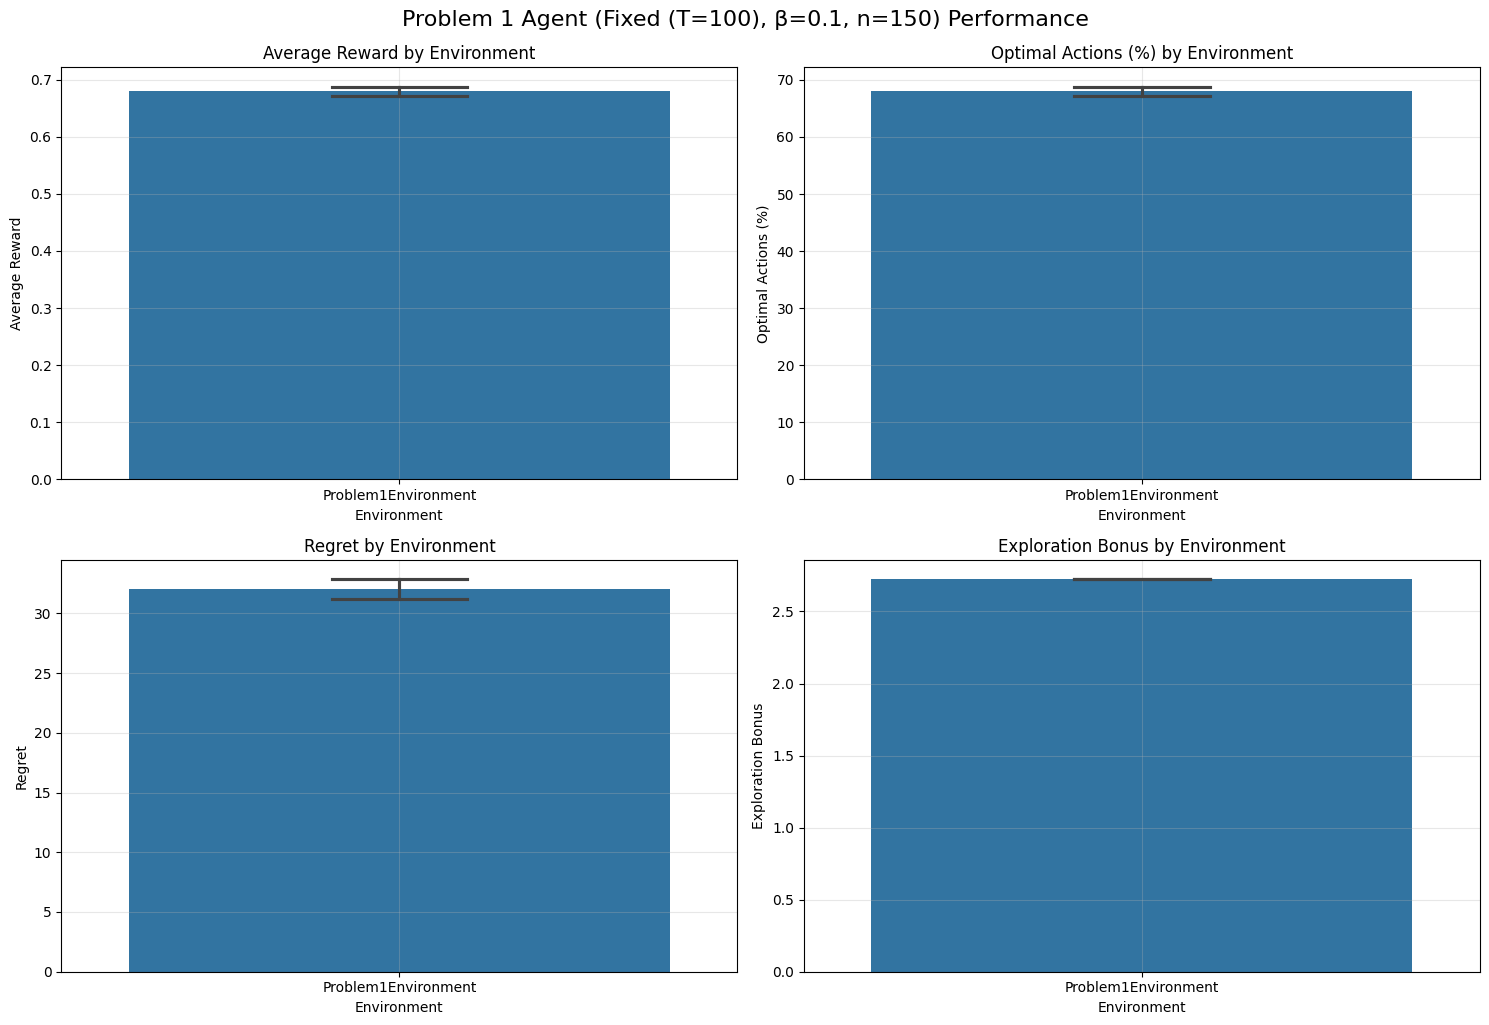

In [40]:
a = evaluate_problem1_agent(fixed_turns=True, exploration_bonus=0.1, n_experiments=150)

### Turnos no fijos

Running Problem1Environment:   0%|          | 0/150 [00:00<?, ?it/s]


==== Problem 1 Agent (Random (T=1-300), β=0.1, n=150) Summary Statistics ====
                     Average Reward_mean  Average Reward_std  \
Environment                                                    
Problem1Environment                0.529               0.059   

                     Average Reward_min  Average Reward_max  \
Environment                                                   
Problem1Environment               0.286               0.765   

                     Optimal Actions (%)_mean  Optimal Actions (%)_std  \
Environment                                                              
Problem1Environment                    52.871                    5.857   

                     Optimal Actions (%)_min  Optimal Actions (%)_max  \
Environment                                                             
Problem1Environment                   28.571                   76.471   

                     Regret_mean  Regret_std  Exploration Bonus_mean  \
Environment            

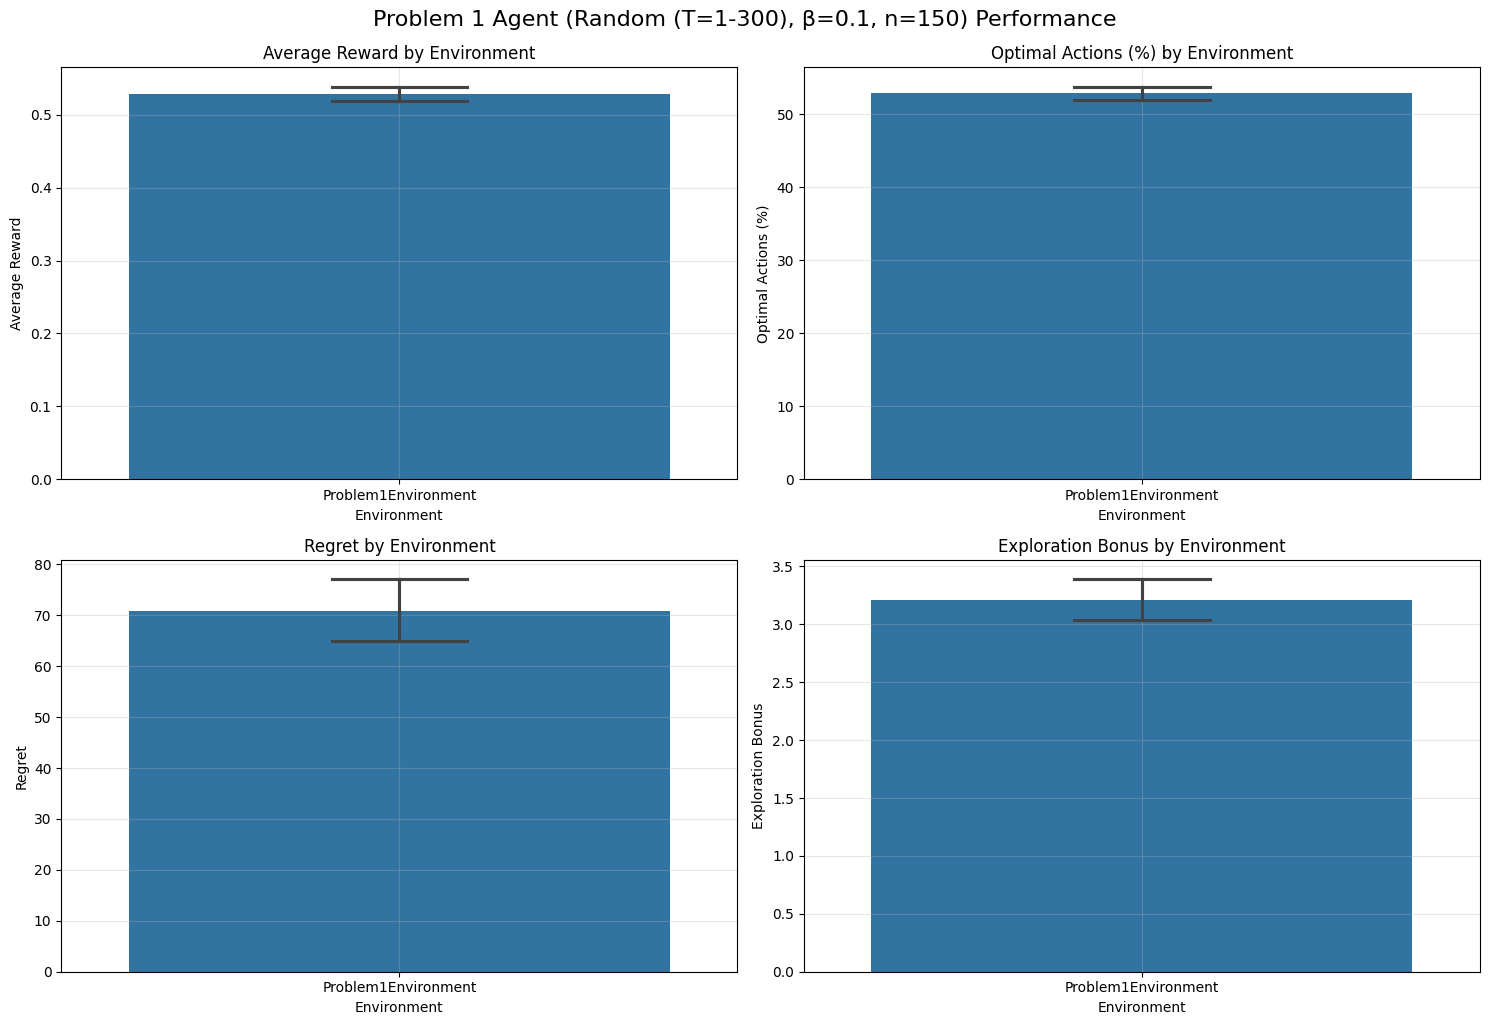

In [41]:
a = evaluate_problem1_agent(fixed_turns=False, exploration_bonus=.1, n_experiments=150)

#### Grid para variar bonus de exploración

Problem 1 β Analysis:   0%|          | 0/1000 [00:00<?, ?it/s]

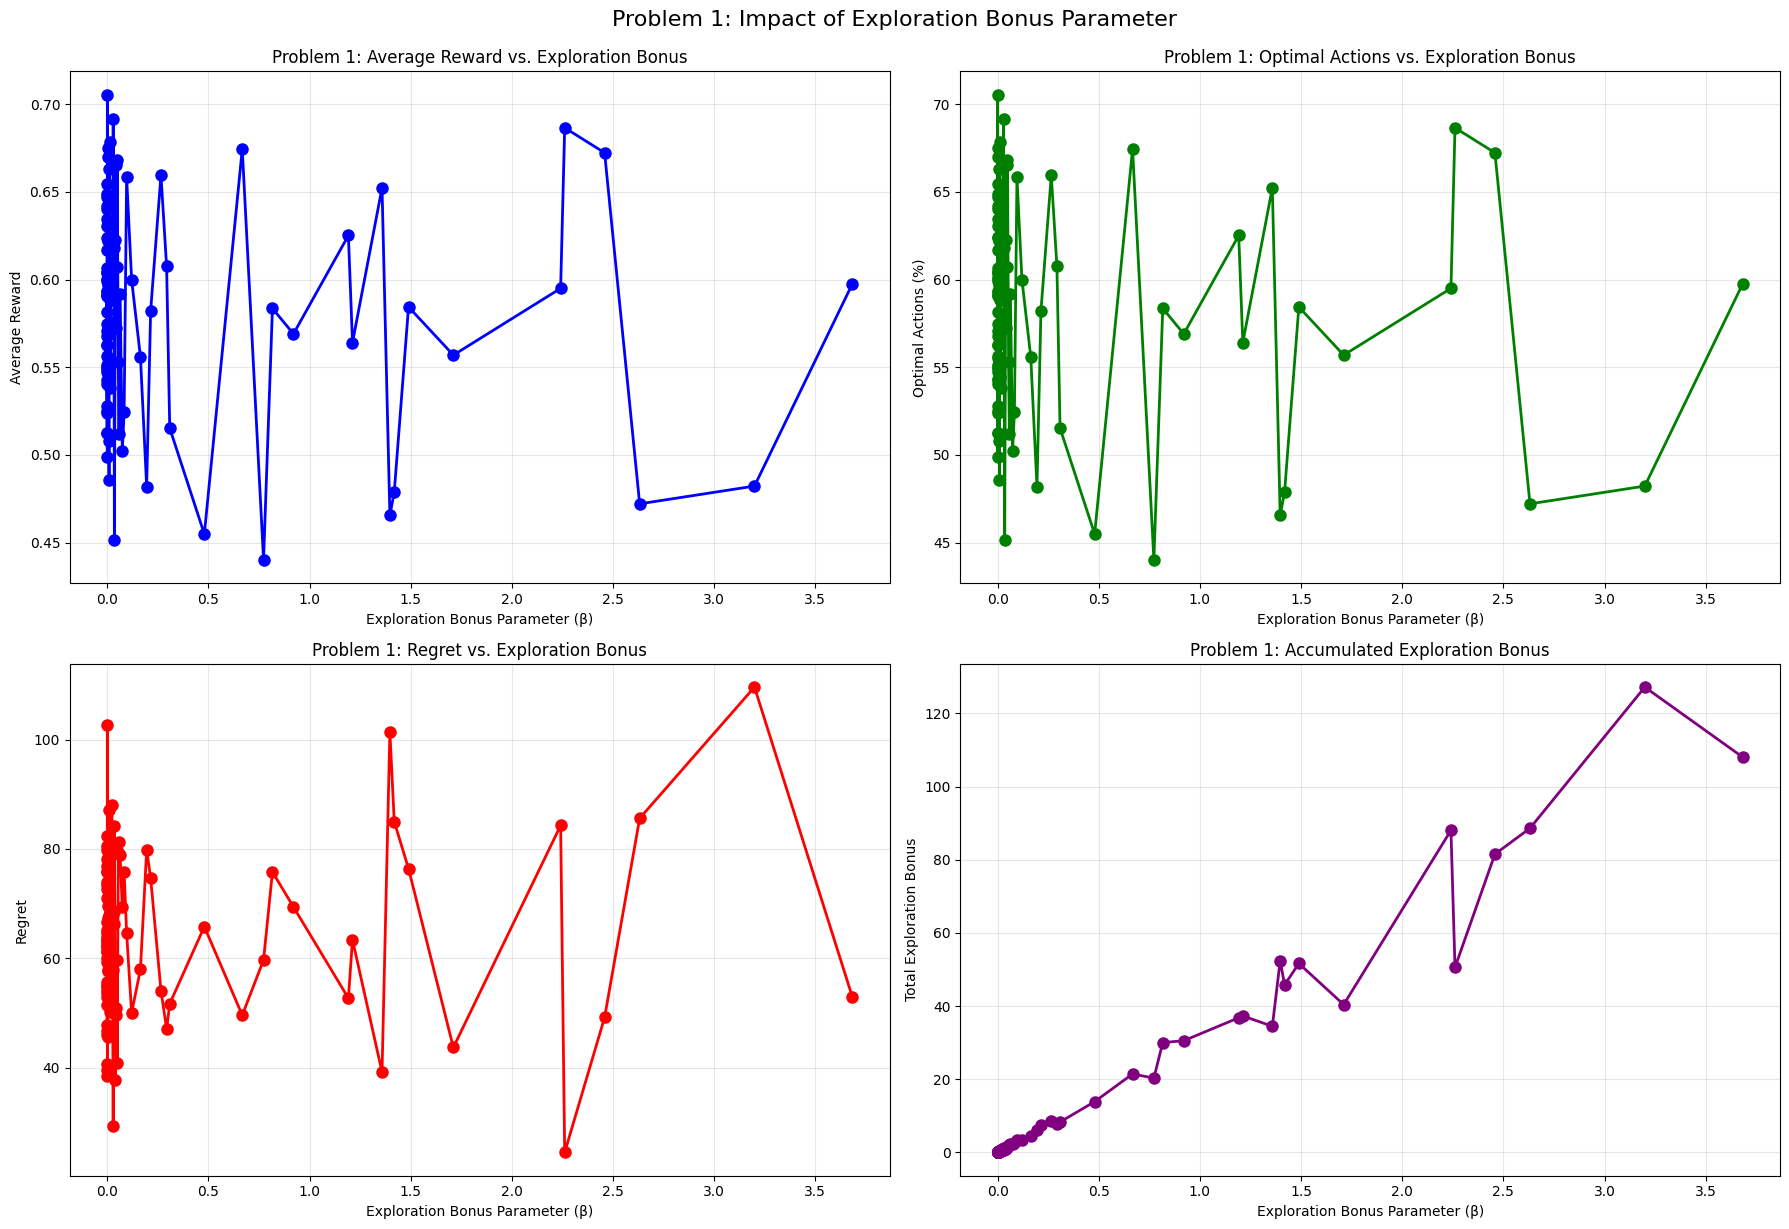

/var/folders/1_/0gj_v5x54fxd8gllt64jsbp80000gn/T/ipykernel_90813/2100408109.py:1836: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=labels, patch_artist=True)


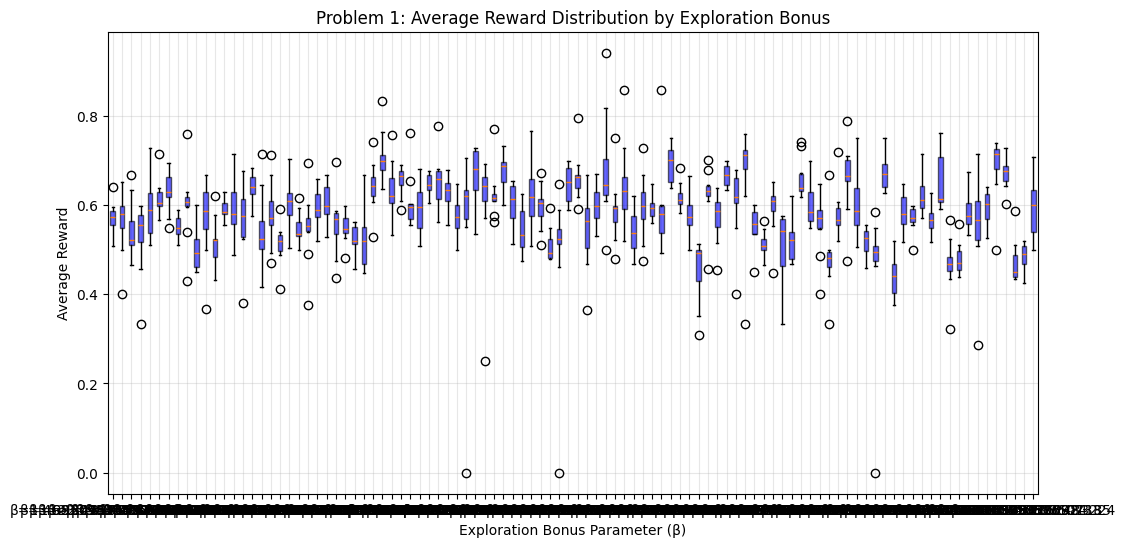

/var/folders/1_/0gj_v5x54fxd8gllt64jsbp80000gn/T/ipykernel_90813/2100408109.py:1836: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=labels, patch_artist=True)


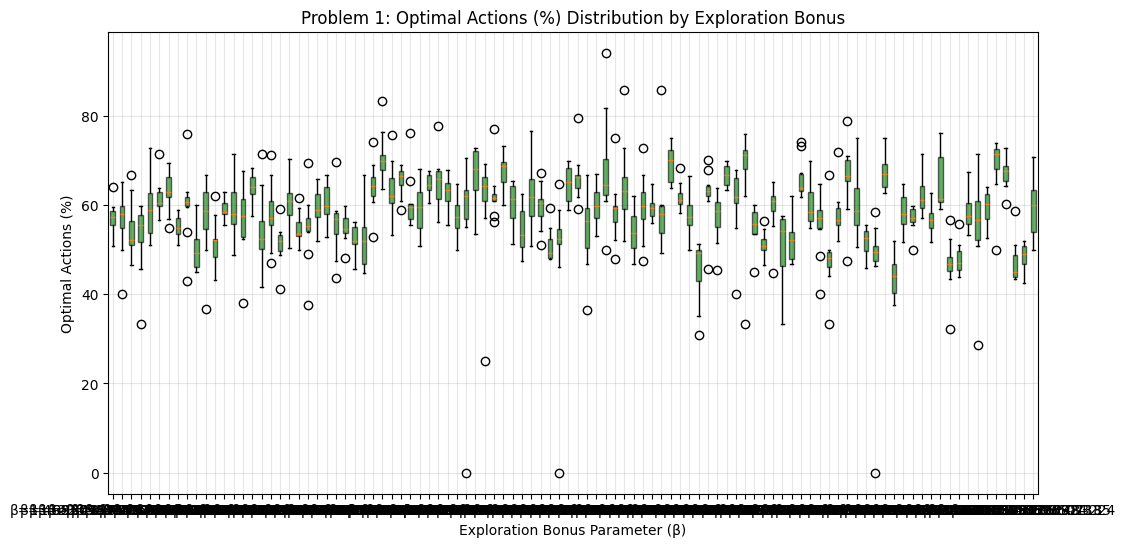

/var/folders/1_/0gj_v5x54fxd8gllt64jsbp80000gn/T/ipykernel_90813/2100408109.py:1836: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=labels, patch_artist=True)


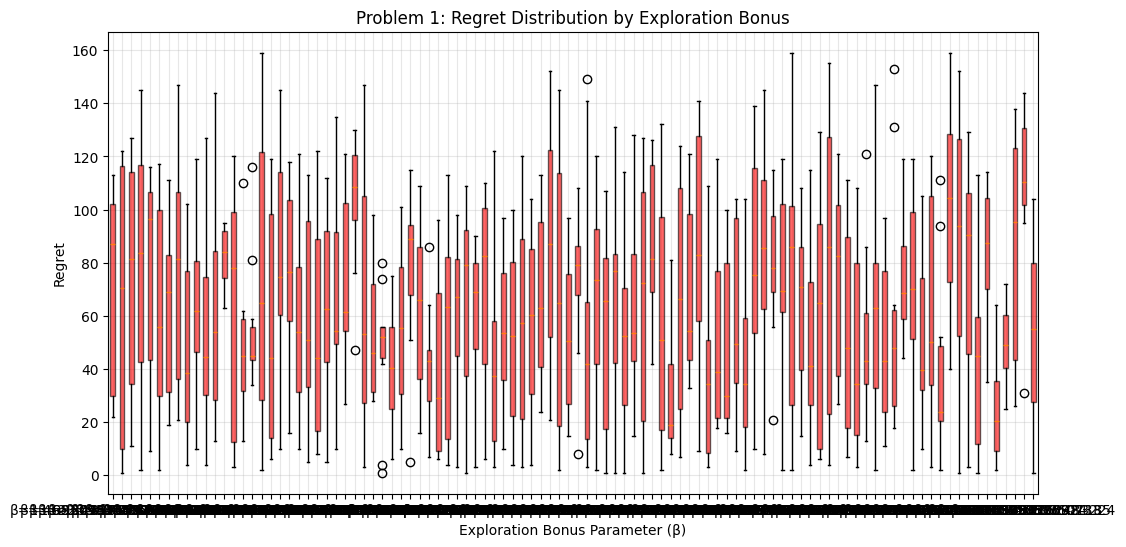


Problem 1: Summary Table of Metrics by Exploration Bonus
    Exploration Bonus (β)  Average Reward  Optimal Actions (%)  Regret  \
0                  0.0000          0.5680              56.7992    71.0   
1                  0.0000          0.5628              56.2849    63.9   
2                  0.0000          0.5429              54.2942    73.5   
3                  0.0000          0.5281              52.8122    79.9   
4                  0.0000          0.5994              59.9375    76.0   
..                    ...             ...                  ...     ...   
95                 2.2610          0.6866              68.6631    24.5   
96                 2.4583          0.6724              67.2362    49.2   
97                 2.6316          0.4721              47.2076    85.6   
98                 3.1991          0.4822              48.2219   109.6   
99                 3.6833          0.5976              59.7633    52.9   

    Total Exploration Bonus  
0                    0.

In [42]:
bonus_values = sample_regularization_lambdas(n=100,low=1e-5,high=5)
a = evaluate_problem1_with_varying_bonus(bonus_values=bonus_values, fixed_turns=False, n_experiments=10)

## Agente 2

In [39]:
def problem2_agent(env_info: Dict) -> int:
    """
    Agente mejorado para Problema 2
    """
    current_turn = env_info['current_turn']
    total_turns = env_info['total_turns']
    history = env_info['history']
    
    # Inicialización mejorada
    if 'agent_data' not in env_info:
        env_info['agent_data'] = {
            'arm1': {
                'rewards': [],
                'pulls': 0,
                'last_prob': None,
                'success_count': np.zeros(2),
                'transition_count': np.zeros((2, 2)),
                'recent_rewards': []  # Para detectar tendencias
            },
            'arm2': {
                'rewards': [],
                'pulls': 0,
                'last_prob': None,
                'success_count': np.zeros(2),
                'transition_count': np.zeros((2, 2)),
                'recent_rewards': []
            }
        }

    # FASE 1: Selección estratégica del brazo a consultar
    arm_to_query = select_arm_to_query(
        env_info['agent_data'], 
        current_turn,
        total_turns
    )
    
    # FASE 2: Procesar probabilidad consultada
    if 'query_probability' in env_info:
        queried_prob = env_info['query_probability']
        arm_key = f'arm{arm_to_query + 1}'
        env_info['agent_data'][arm_key]['last_prob'] = queried_prob
        
        # Actualización de creencias con la probabilidad consultada
        update_beliefs_with_query(env_info['agent_data'][arm_key], queried_prob)
    
    # FASE 3: Actualizar con última acción y recompensa
    if len(history['actions']) > 0:
        last_action = history['actions'][-1]
        last_reward = history['rewards'][-1]
        arm_key = f'arm{last_action + 1}'
        arm_data = env_info['agent_data'][arm_key]
        
        # Actualizar estadísticas
        arm_data['rewards'].append(last_reward)
        arm_data['recent_rewards'] = (arm_data['recent_rewards'] + [last_reward])[-10:]
        arm_data['pulls'] += 1
        arm_data['success_count'][int(last_reward)] += 1
    
    # FASE 4: Decisión adaptativa
    return adaptive_decision(
        env_info['agent_data'], 
        arm_to_query, 
        current_turn,
        total_turns
    )

def select_arm_to_query(agent_data, current_turn, total_turns):
    """
    Selección adaptativa del brazo a consultar
    """
    # Fase inicial de exploración
    if current_turn < 15:
        return current_turn % 2
    
    # Calcular incertidumbre y tendencia para cada brazo
    uncertainty1 = calculate_uncertainty(agent_data['arm1'], current_turn, total_turns)
    uncertainty2 = calculate_uncertainty(agent_data['arm2'], current_turn, total_turns)
    
    # Ajustar por tendencia reciente
    trend1 = calculate_trend(agent_data['arm1']['recent_rewards'])
    trend2 = calculate_trend(agent_data['arm2']['recent_rewards'])
    
    score1 = uncertainty1 * (1 + 0.2 * trend1)
    score2 = uncertainty2 * (1 + 0.2 * trend2)
    
    return 0 if score1 > score2 else 1

def calculate_uncertainty(arm_data, current_turn, total_turns):
    """
    Cálculo mejorado de incertidumbre
    """
    if arm_data['pulls'] == 0:
        return float('inf')
    
    # Combinar varianza empírica con tiempo desde última consulta
    empirical_variance = np.std(arm_data['rewards']) if len(arm_data['rewards']) > 0 else 1.0
    time_factor = 1.0 if arm_data['last_prob'] is None else (current_turn - arm_data['pulls'])
    
    # Ajustar por fase del juego
    game_progress = current_turn / total_turns
    exploration_weight = max(0.2, 1.0 - game_progress)
    
    return (empirical_variance / np.sqrt(arm_data['pulls'])) * (1 + 0.1 * time_factor) * exploration_weight

def adaptive_decision(agent_data, queried_arm, current_turn, total_turns):
    """
    Decisión que combina Thompson Sampling con adaptación temporal
    """
    # Calcular valores base usando Thompson Sampling
    value1 = sample_beta_value(agent_data['arm1'], queried_arm == 0)
    value2 = sample_beta_value(agent_data['arm2'], queried_arm == 1)
    
    # Ajustar por fase del juego
    game_progress = current_turn / total_turns
    
    if game_progress < 0.3:  # Fase temprana
        # Más exploración
        value1 *= (1 + 0.2 * calculate_uncertainty(agent_data['arm1'], current_turn, total_turns))
        value2 *= (1 + 0.2 * calculate_uncertainty(agent_data['arm2'], current_turn, total_turns))
    elif game_progress > 0.7:  # Fase tardía
        # Más explotación
        if agent_data['arm1']['last_prob'] is not None:
            value1 = 0.8 * agent_data['arm1']['last_prob'] + 0.2 * value1
        if agent_data['arm2']['last_prob'] is not None:
            value2 = 0.8 * agent_data['arm2']['last_prob'] + 0.2 * value2
    
    return 0 if value1 > value2 else 1

def calculate_trend(recent_rewards):
    """
    Calcula la tendencia de las recompensas recientes
    """
    if len(recent_rewards) < 2:
        return 0
    
    return np.mean(np.diff(recent_rewards))

### Turnos Fijos

Running Problem2Environment:   0%|          | 0/150 [00:00<?, ?it/s]


==== Problem 2 Agent (Fixed (T=100), β=0.1, n=150) Summary Statistics ====
                     Average Reward_mean  Average Reward_std  \
Environment                                                    
Problem2Environment                0.488               0.049   

                     Average Reward_min  Average Reward_max  \
Environment                                                   
Problem2Environment                0.37                0.64   

                     Optimal Actions (%)_mean  Optimal Actions (%)_std  \
Environment                                                              
Problem2Environment                    48.753                     4.86   

                     Optimal Actions (%)_min  Optimal Actions (%)_max  \
Environment                                                             
Problem2Environment                     37.0                     64.0   

                     Regret_mean  Regret_std  Exploration Bonus_mean  \
Environment               

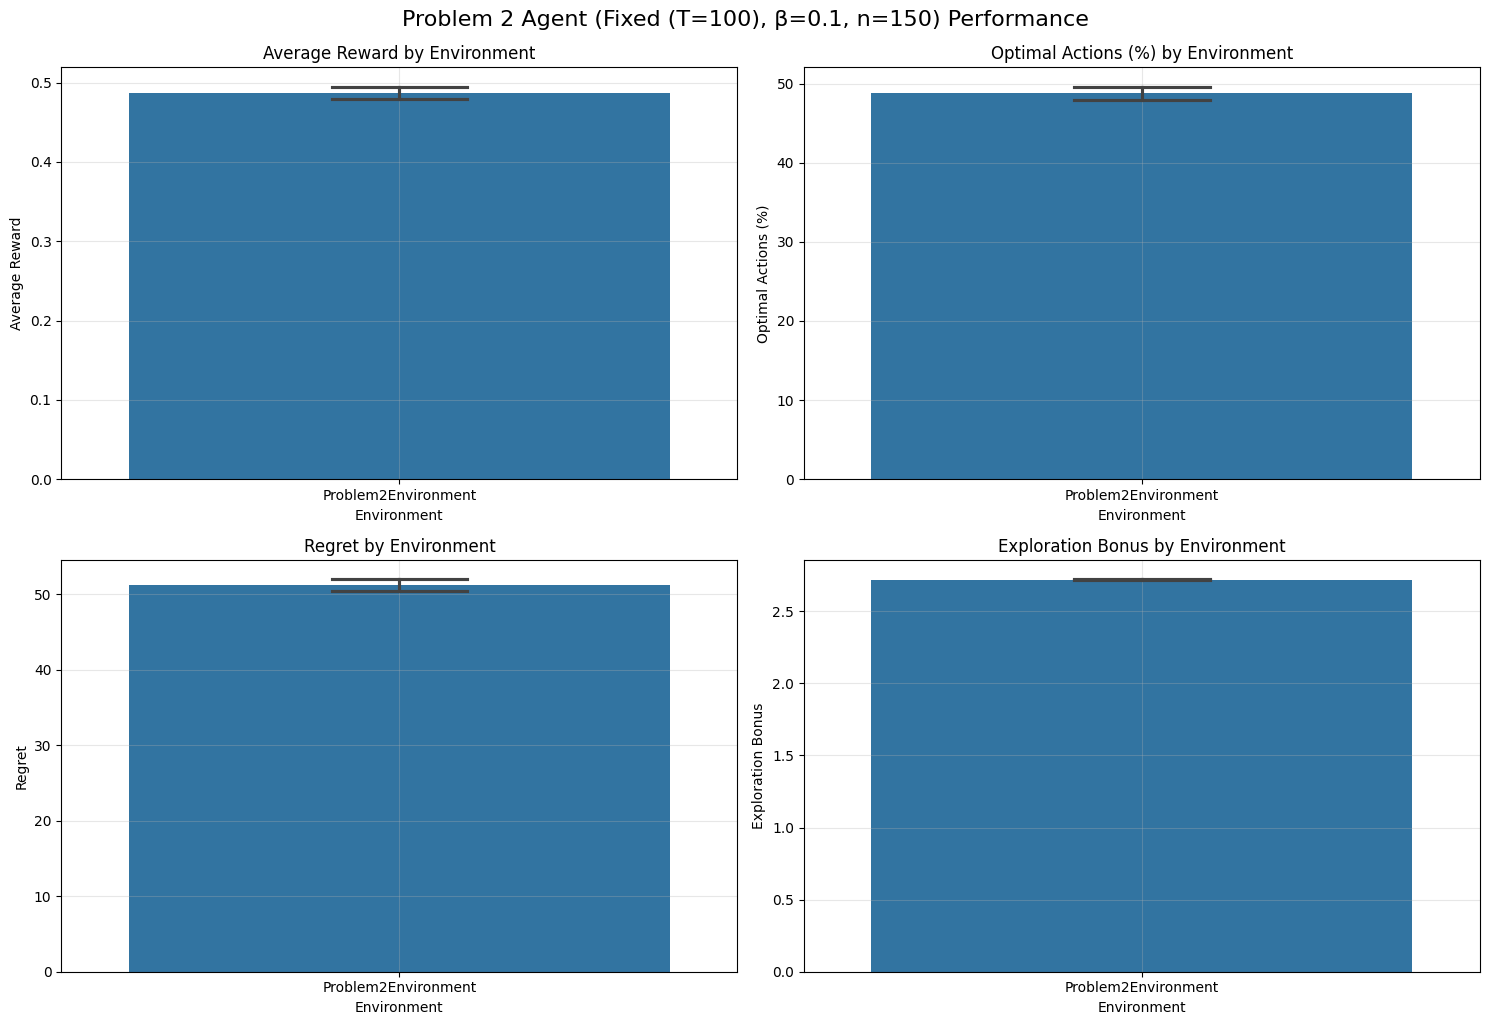

In [40]:
a = evaluate_problem2_agent(fixed_turns=True, exploration_bonus=.1, n_experiments=150)

### Turnos no Fijos

Running Problem2Environment:   0%|          | 0/150 [00:00<?, ?it/s]


==== Problem 2 Agent (Random (T=1-300), β=0.1, n=150) Summary Statistics ====
                     Average Reward_mean  Average Reward_std  \
Environment                                                    
Problem2Environment                0.425                0.08   

                     Average Reward_min  Average Reward_max  \
Environment                                                   
Problem2Environment                 0.0                 1.0   

                     Optimal Actions (%)_mean  Optimal Actions (%)_std  \
Environment                                                              
Problem2Environment                    42.537                    7.999   

                     Optimal Actions (%)_min  Optimal Actions (%)_max  \
Environment                                                             
Problem2Environment                      0.0                    100.0   

                     Regret_mean  Regret_std  Exploration Bonus_mean  \
Environment            

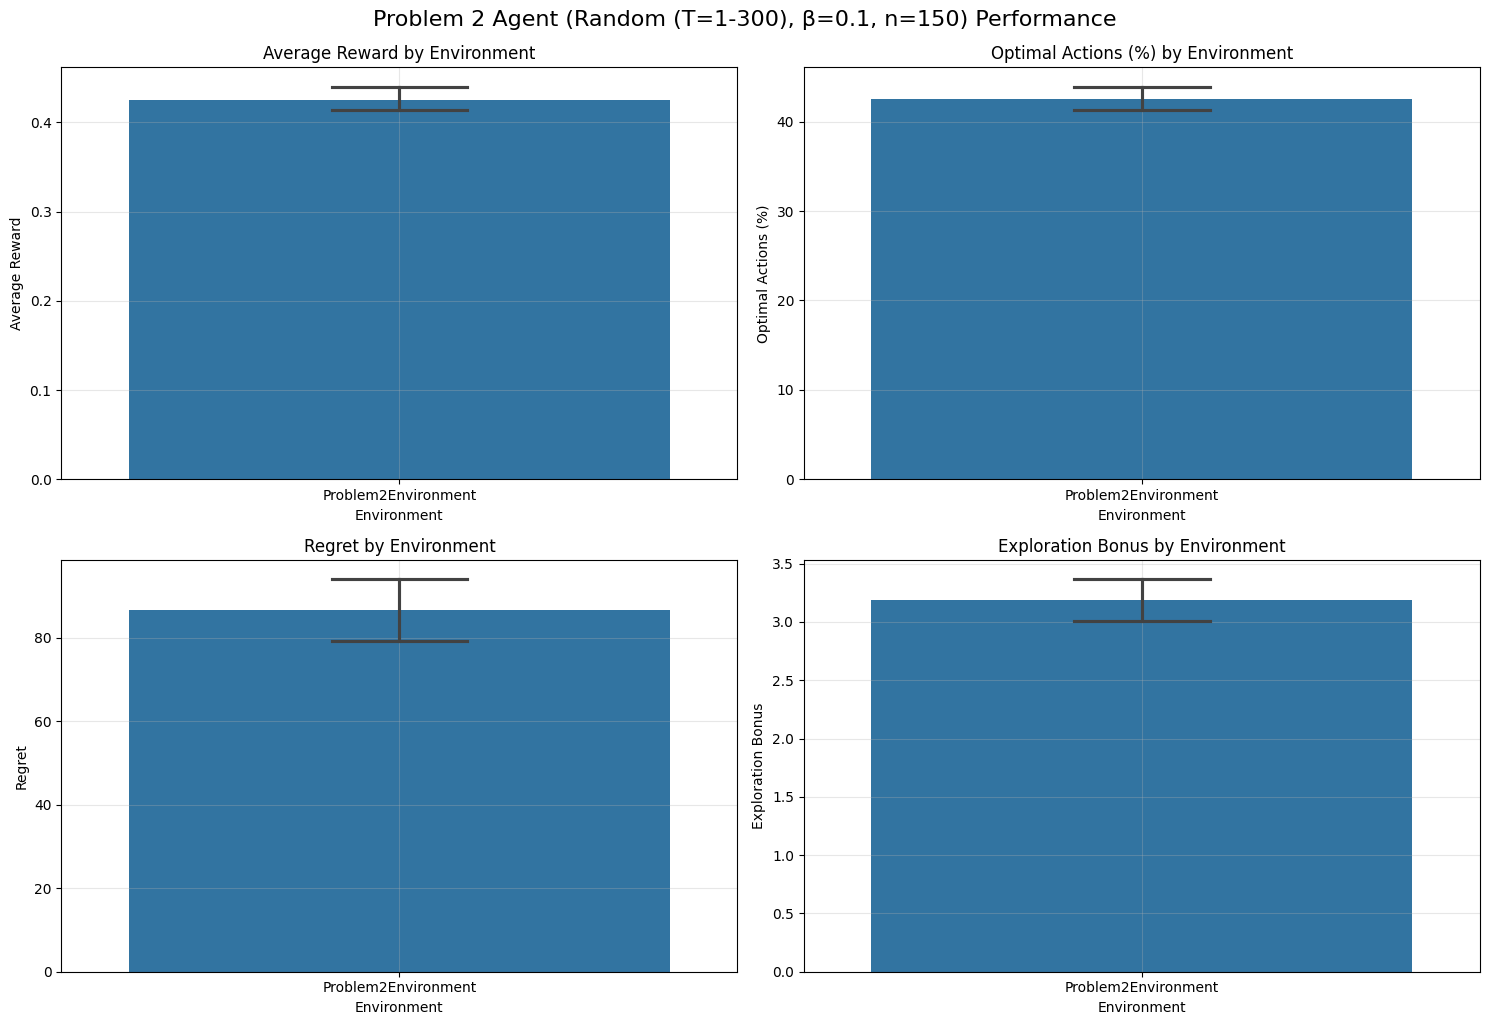

In [41]:
a = evaluate_problem2_agent(fixed_turns=False, exploration_bonus=.1, n_experiments=150)

#### Grid para variar bonus de exploración

Problem 2 β Analysis:   0%|          | 0/1000 [00:00<?, ?it/s]

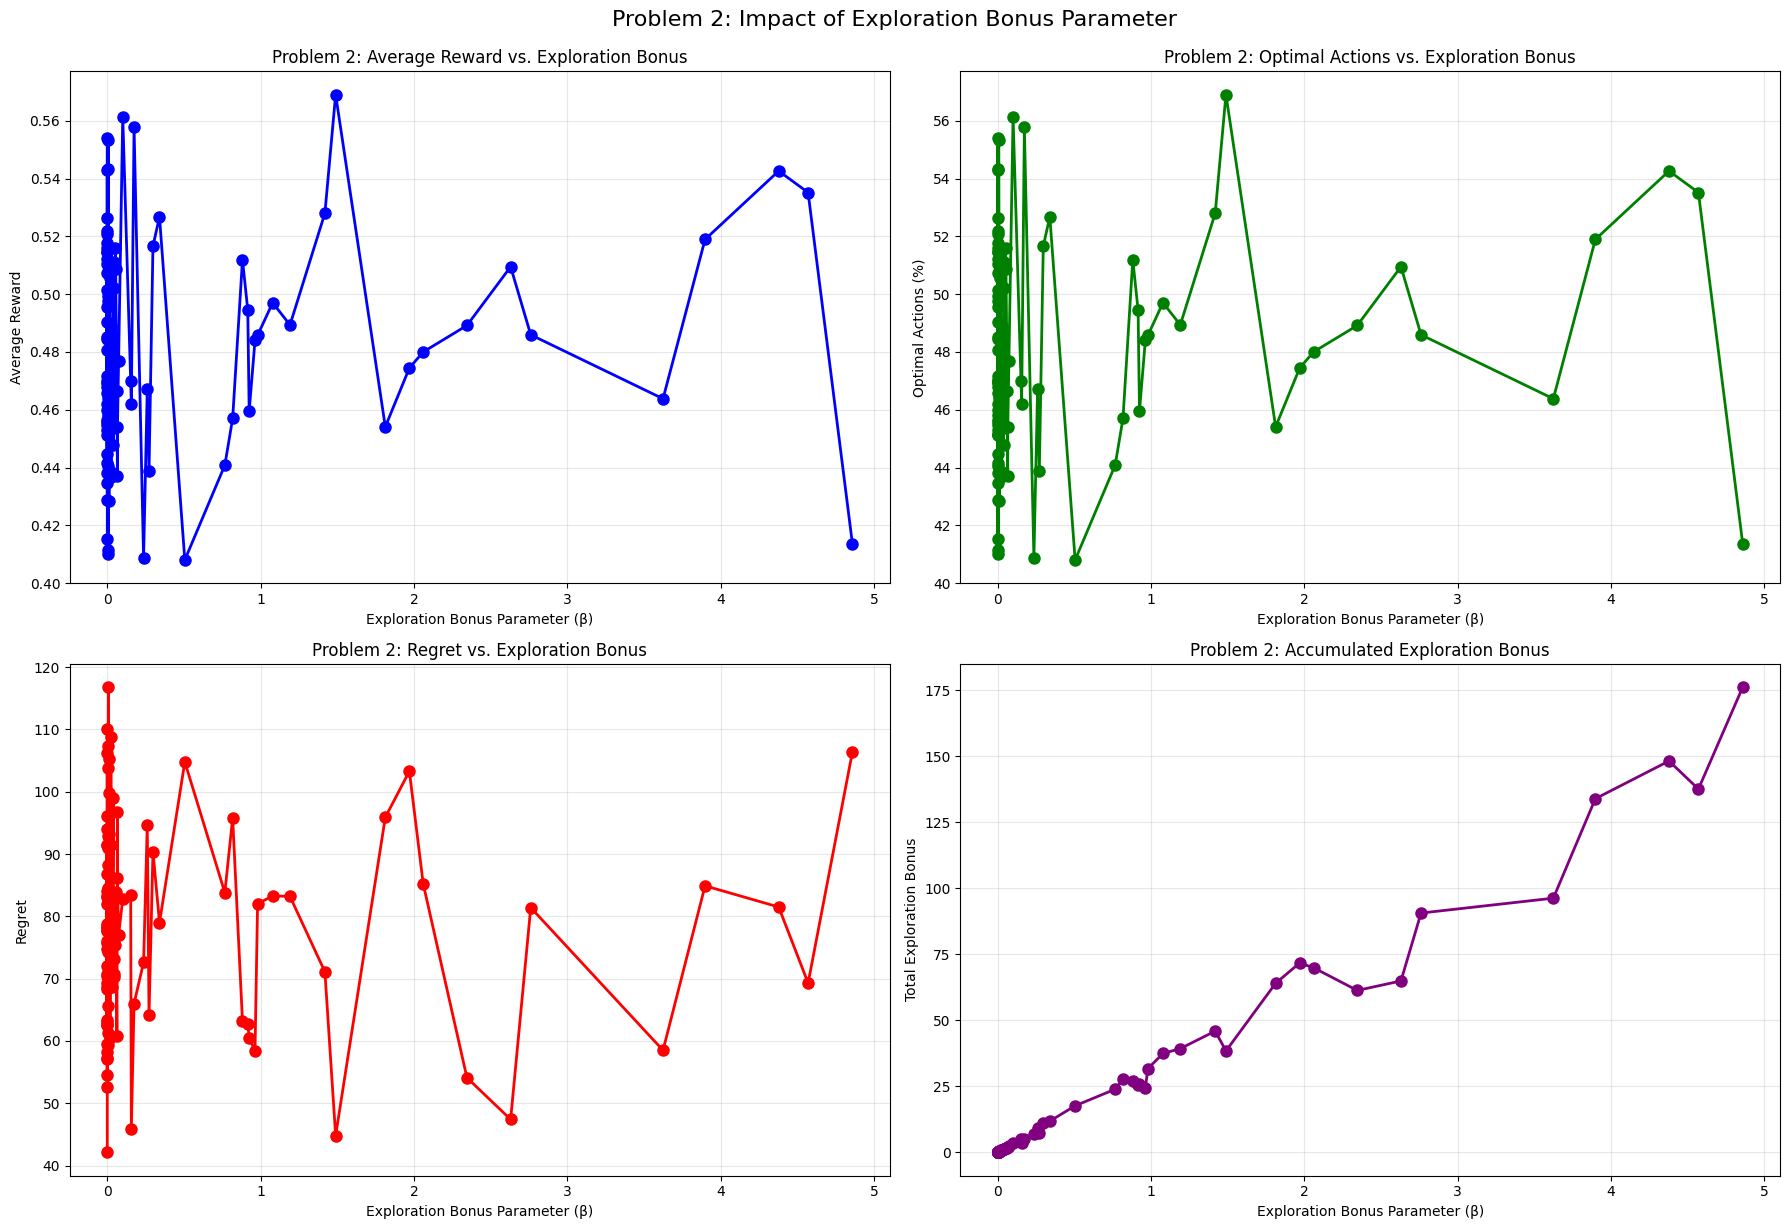

/var/folders/1_/0gj_v5x54fxd8gllt64jsbp80000gn/T/ipykernel_90813/2100408109.py:1836: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=labels, patch_artist=True)


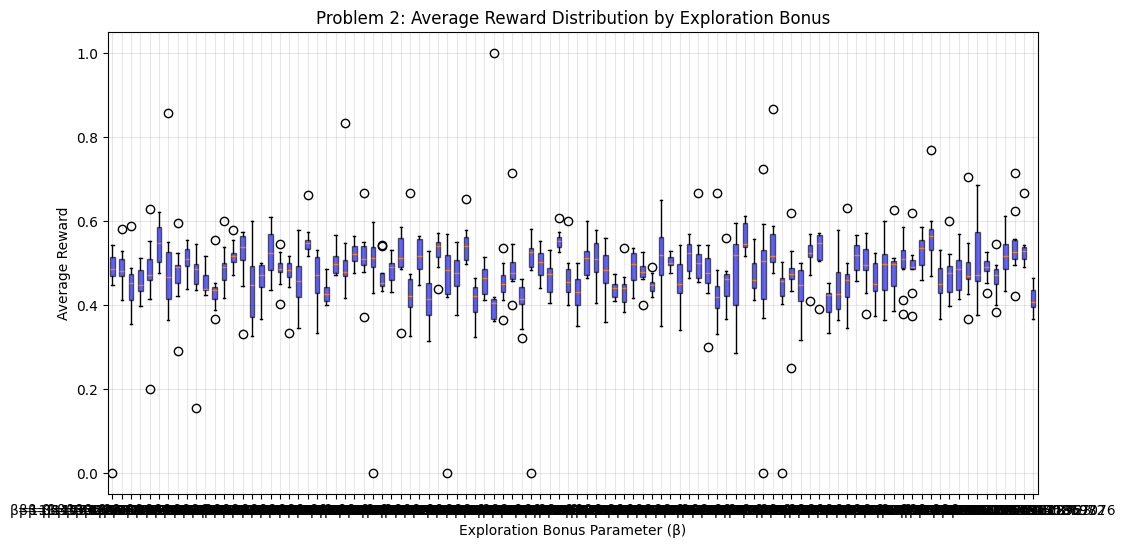

/var/folders/1_/0gj_v5x54fxd8gllt64jsbp80000gn/T/ipykernel_90813/2100408109.py:1836: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=labels, patch_artist=True)


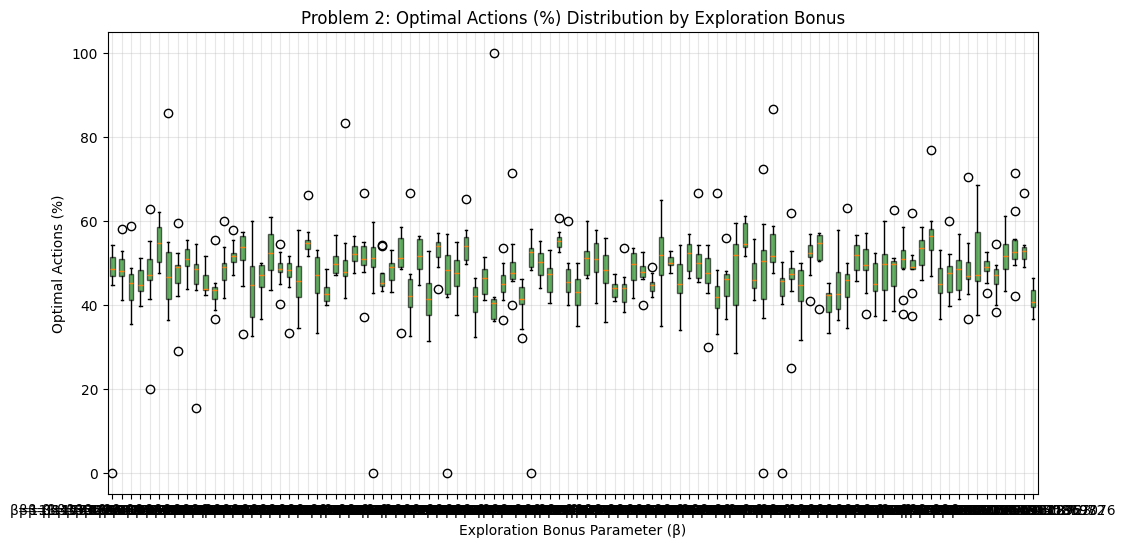

/var/folders/1_/0gj_v5x54fxd8gllt64jsbp80000gn/T/ipykernel_90813/2100408109.py:1836: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=labels, patch_artist=True)


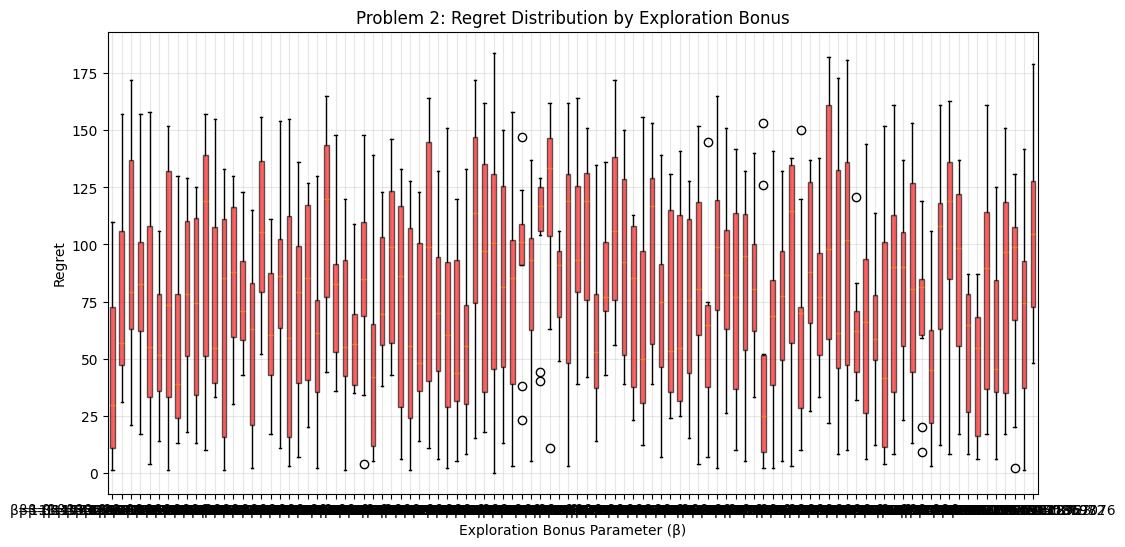


Problem 2: Summary Table of Metrics by Exploration Bonus
    Exploration Bonus (β)  Average Reward  Optimal Actions (%)  Regret  \
0                  0.0000          0.4448              44.4751    42.1   
1                  0.0000          0.4852              48.5200    76.1   
2                  0.0000          0.4511              45.1090    91.5   
3                  0.0000          0.4557              45.5728    83.1   
4                  0.0000          0.4658              46.5815    68.6   
..                    ...             ...                  ...     ...   
95                 3.6247          0.4638              46.3809    58.5   
96                 3.8990          0.5190              51.8962    84.9   
97                 4.3792          0.5427              54.2656    81.5   
98                 4.5710          0.5352              53.5193    69.3   
99                 4.8601          0.4135              41.3545   106.4   

    Total Exploration Bonus  
0                    0.

In [63]:
bonus_values = sample_regularization_lambdas(n=100,low=1e-5,high=5)
a = evaluate_problem2_with_varying_bonus(bonus_values=bonus_values, fixed_turns=False, n_experiments=10)

## Agente 3

In [42]:
def problem3_agent(env_info: Dict) -> int:
    """
    Agente con UCB Contextual y Thompson Sampling Correlacionado para Problema 3
    """
    # Extraer información del ambiente
    current_turn = env_info['current_turn']
    total_turns = env_info['total_turns']
    history = env_info['history']
    
    # Para Problema 3, la matriz de transición está en 'joint_transition_matrix'
    transition_matrix = env_info.get('joint_transition_matrix', None)
    if transition_matrix is None:
        # Si no está disponible, usar matriz por defecto
        transition_matrix = np.ones((4, 4)) / 4
    
    # Inicializar estructuras
    if 'agent_data' not in env_info:
        env_info['agent_data'] = {
            'forward_belief': np.ones(4) / 4,  # Estado conjunto (2x2 = 4 estados)
            'pulls': np.zeros(2),
            'rewards': [[], []],
            'last_queried': -1,
            'last_prob': None,
            'contextual_values': np.zeros((2, 4)),
            'correlation_matrix': np.eye(2)
        }
    
    # FASE 1: Seleccionar brazo para consultar
    arm_to_query = select_query_arm_contextual(
        env_info['agent_data'],
        transition_matrix,
        current_turn,
        total_turns
    )
    
    # FASE 2: Actualizar con probabilidad consultada
    if 'query_probability' in env_info:
        queried_prob = env_info['query_probability']
        update_beliefs_with_correlation(
            env_info['agent_data'],
            queried_prob,
            arm_to_query,
            current_turn
        )
    
    # FASE 3: Actualizar con última acción y recompensa
    if len(history['actions']) > 0:
        last_action = history['actions'][-1]
        last_reward = history['rewards'][-1]
        update_statistics(env_info['agent_data'], last_action, last_reward)
    
    # FASE 4: Decisión híbrida UCB-Thompson
    return hybrid_ucb_thompson_decision(
        env_info['agent_data'],
        transition_matrix,
        current_turn,
        total_turns,
        arm_to_query
    )

def select_query_arm_contextual(agent_data, transition_matrix, current_turn, total_turns):
    """
    Selecciona brazo para consultar usando UCB contextual
    """
    if current_turn < 15:
        return current_turn % 2
    
    ucb_values = calculate_contextual_ucb(
        agent_data,
        transition_matrix,
        current_turn
    )
    
    correlation_factor = np.abs(agent_data['correlation_matrix'][0,1])
    if correlation_factor > 0.3:
        uncertainty1 = calculate_uncertainty(agent_data, 0)
        uncertainty2 = calculate_uncertainty(agent_data, 1)
        ucb_values += np.array([uncertainty1, uncertainty2]) * correlation_factor
    
    return np.argmax(ucb_values)

def calculate_uncertainty(agent_data, arm):
    """
    Calcula incertidumbre para un brazo
    """
    if len(agent_data['rewards'][arm]) == 0:
        return float('inf')
    return np.std(agent_data['rewards'][arm]) / np.sqrt(len(agent_data['rewards'][arm]) + 1)

def update_statistics(agent_data, action, reward):
    """
    Actualiza estadísticas del brazo
    """
    agent_data['pulls'][action] += 1
    agent_data['rewards'][action].append(reward)
    
    # Actualizar correlación si hay suficientes datos
    if len(agent_data['rewards'][0]) > 0 and len(agent_data['rewards'][1]) > 0:
        window_size = min(20, len(agent_data['rewards'][0]), len(agent_data['rewards'][1]))
        rewards1 = agent_data['rewards'][0][-window_size:]
        rewards2 = agent_data['rewards'][1][-window_size:]
        if len(rewards1) == len(rewards2):
            correlation = np.corrcoef(rewards1, rewards2)[0,1]
            agent_data['correlation_matrix'] = np.array([[1, correlation], 
                                                       [correlation, 1]])

def calculate_contextual_ucb(agent_data, transition_matrix, current_turn):
    """
    Calcula valores UCB considerando contexto
    """
    ucb_values = np.zeros(2)
    
    for arm in range(2):
        if agent_data['pulls'][arm] == 0:
            ucb_values[arm] = float('inf')
            continue
        
        # Valor medio
        mean_reward = np.mean(agent_data['rewards'][arm])
        
        # Término de exploración
        exploration = np.sqrt(2 * np.log(current_turn) / agent_data['pulls'][arm])
        
        # Factor contextual basado en la creencia forward
        context_factor = 1.0
        if len(agent_data['rewards'][arm]) > 0:
            recent_success_rate = np.mean(agent_data['rewards'][arm][-5:])
            context_factor = 1.0 + recent_success_rate
        
        ucb_values[arm] = mean_reward + exploration * context_factor
    
    return ucb_values

def hybrid_ucb_thompson_decision(agent_data, transition_matrix, current_turn, total_turns, queried_arm):
    """
    Decisión híbrida UCB-Thompson
    """
    # Calcular valores UCB
    ucb_values = calculate_contextual_ucb(agent_data, transition_matrix, current_turn)
    
    # Calcular valores Thompson
    thompson_values = np.zeros(2)
    for arm in range(2):
        if len(agent_data['rewards'][arm]) > 0:
            successes = sum(agent_data['rewards'][arm])
            failures = len(agent_data['rewards'][arm]) - successes
            thompson_values[arm] = np.random.beta(successes + 1, failures + 1)
        else:
            thompson_values[arm] = 0.5
    
    # Combinar valores según fase del juego
    progress = current_turn / total_turns
    if progress < 0.3:
        final_values = 0.7 * ucb_values + 0.3 * thompson_values
    elif progress < 0.7:
        final_values = 0.5 * ucb_values + 0.5 * thompson_values
    else:
        final_values = 0.3 * ucb_values + 0.7 * thompson_values
    
    # Ajustar por probabilidad consultada
    if agent_data['last_prob'] is not None and queried_arm != -1:
        final_values[queried_arm] = 0.6 * agent_data['last_prob'] + 0.4 * final_values[queried_arm]
    
    return np.argmax(final_values)

### Turnos Fijos

Running Problem3Environment:   0%|          | 0/150 [00:00<?, ?it/s]


==== Problem 3 Agent (Fixed (T=100), β=0.1, n=150) Summary Statistics ====
                     Average Reward_mean  Average Reward_std  \
Environment                                                    
Problem3Environment                0.526                0.27   

                     Average Reward_min  Average Reward_max  \
Environment                                                   
Problem3Environment                0.07                0.93   

                     Optimal Actions (%)_mean  Optimal Actions (%)_std  \
Environment                                                              
Problem3Environment                     52.64                   26.951   

                     Optimal Actions (%)_min  Optimal Actions (%)_max  \
Environment                                                             
Problem3Environment                      7.0                     93.0   

                     Regret_mean  Regret_std  Exploration Bonus_mean  \
Environment               

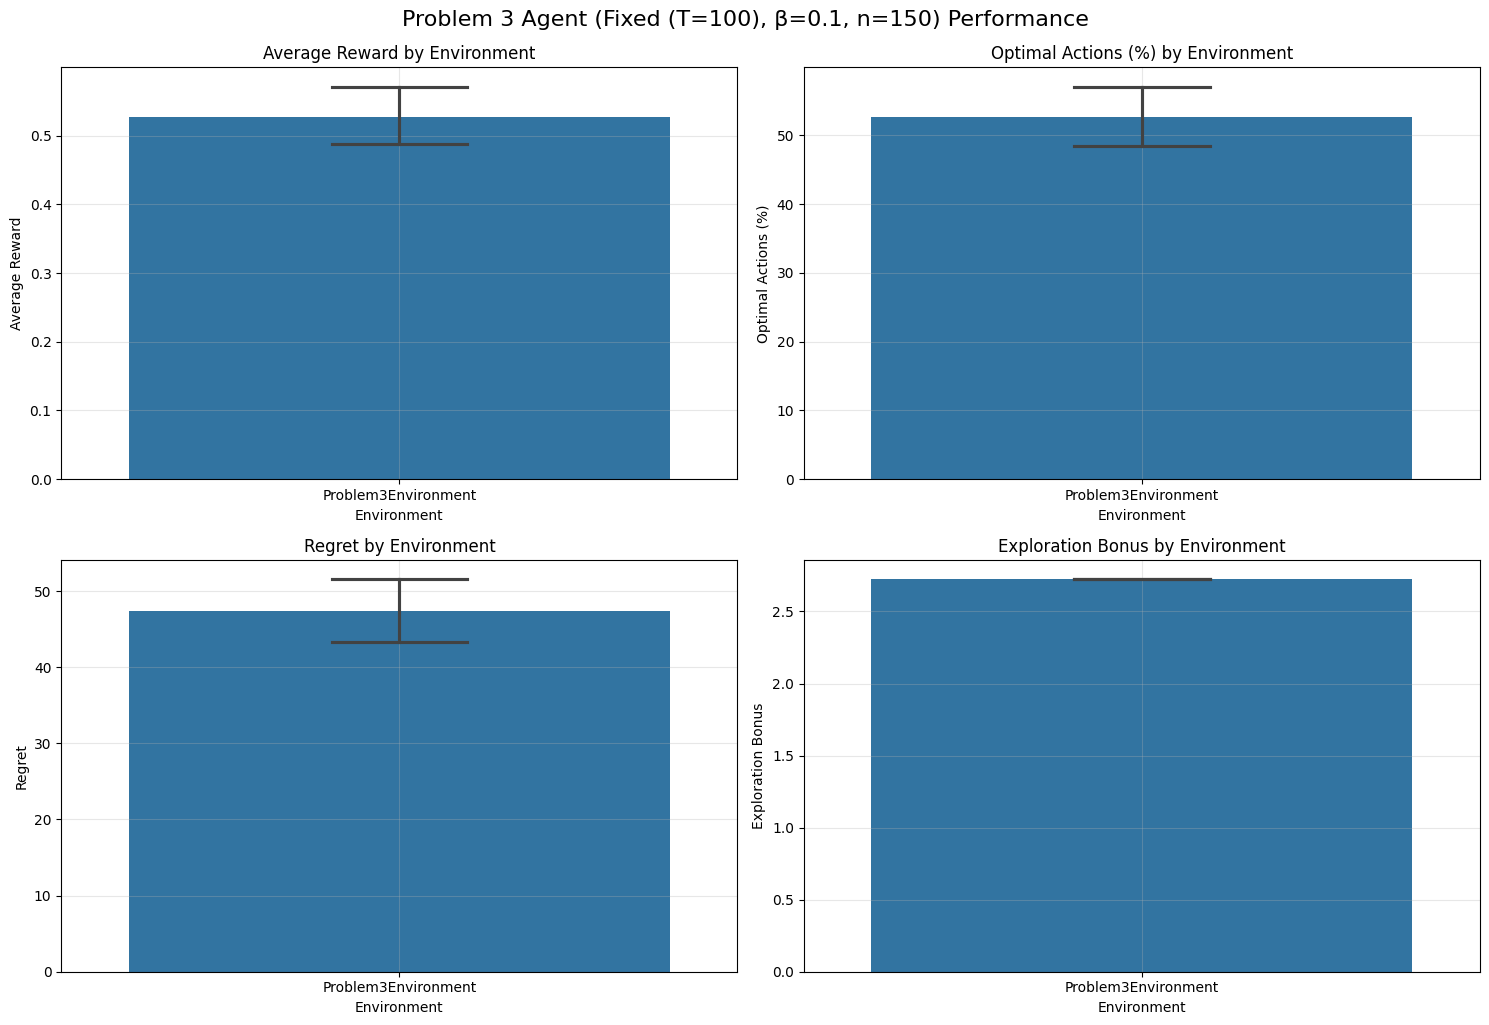

In [43]:

a = evaluate_problem3_agent(fixed_turns=True, exploration_bonus=.1, n_experiments=150)

### Turnos no fijos

Running Problem3Environment:   0%|          | 0/150 [00:00<?, ?it/s]


==== Problem 3 Agent (Random (T=1-300), β=0.1, n=150) Summary Statistics ====
                     Average Reward_mean  Average Reward_std  \
Environment                                                    
Problem3Environment                0.567                0.33   

                     Average Reward_min  Average Reward_max  \
Environment                                                   
Problem3Environment                 0.0                 1.0   

                     Optimal Actions (%)_mean  Optimal Actions (%)_std  \
Environment                                                              
Problem3Environment                    56.728                   33.029   

                     Optimal Actions (%)_min  Optimal Actions (%)_max  \
Environment                                                             
Problem3Environment                      0.0                    100.0   

                     Regret_mean  Regret_std  Exploration Bonus_mean  \
Environment            

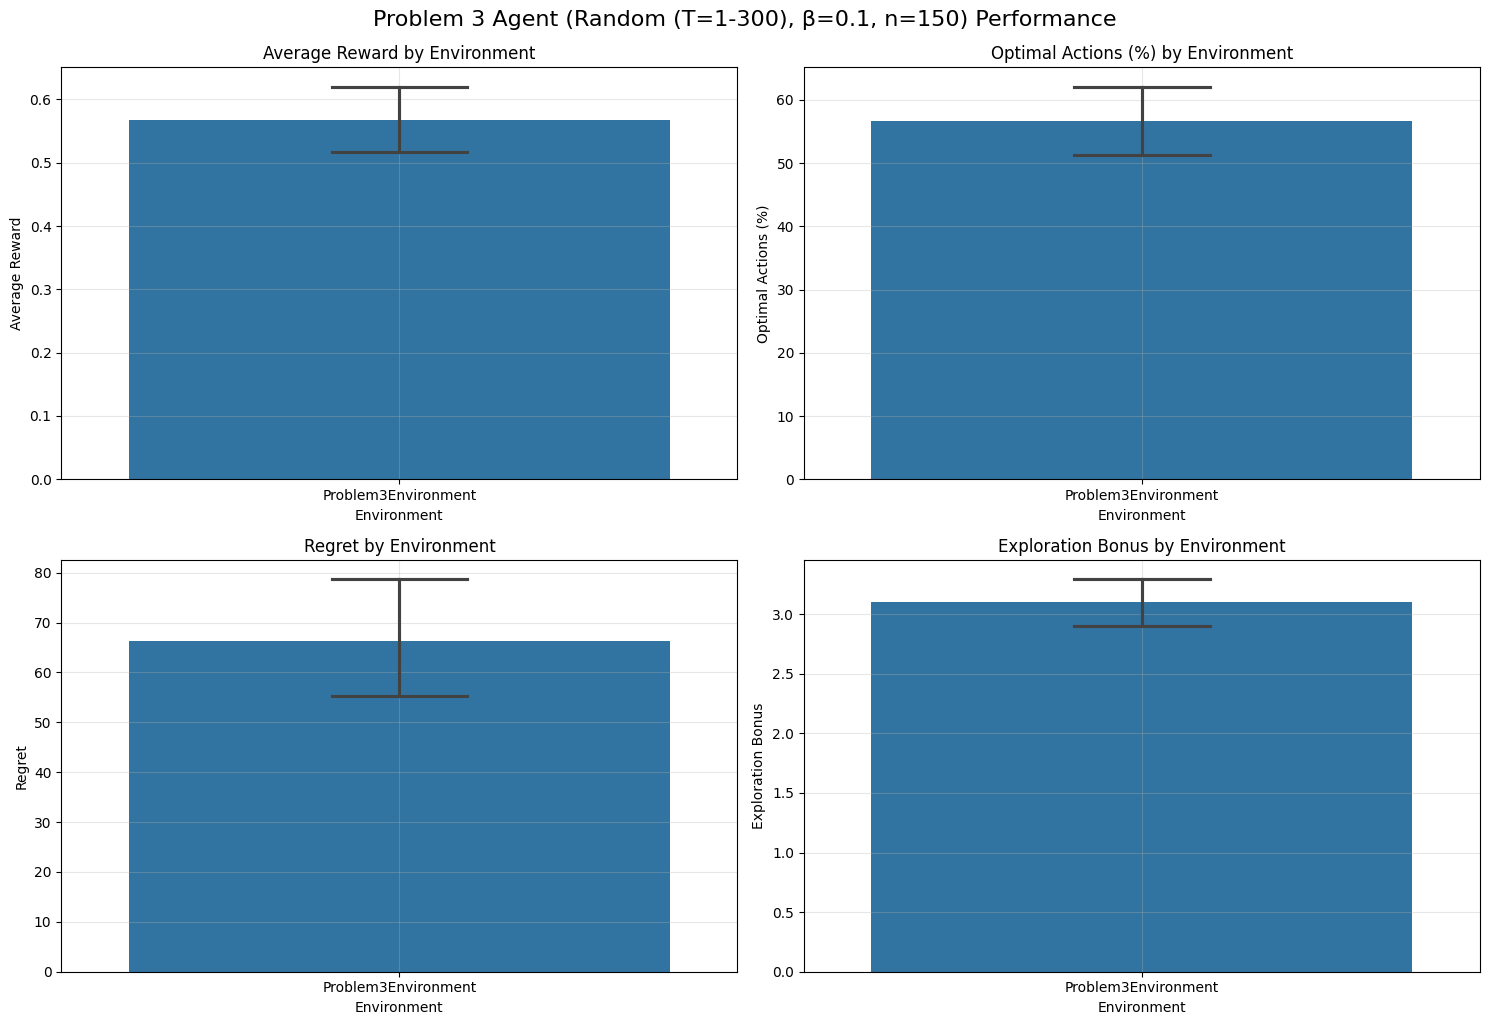

In [44]:
a = evaluate_problem3_agent(fixed_turns=False, exploration_bonus=.1, n_experiments=150)

#### Grid para variar bonus de exploración

Problem 3 β Analysis:   0%|          | 0/1000 [00:00<?, ?it/s]

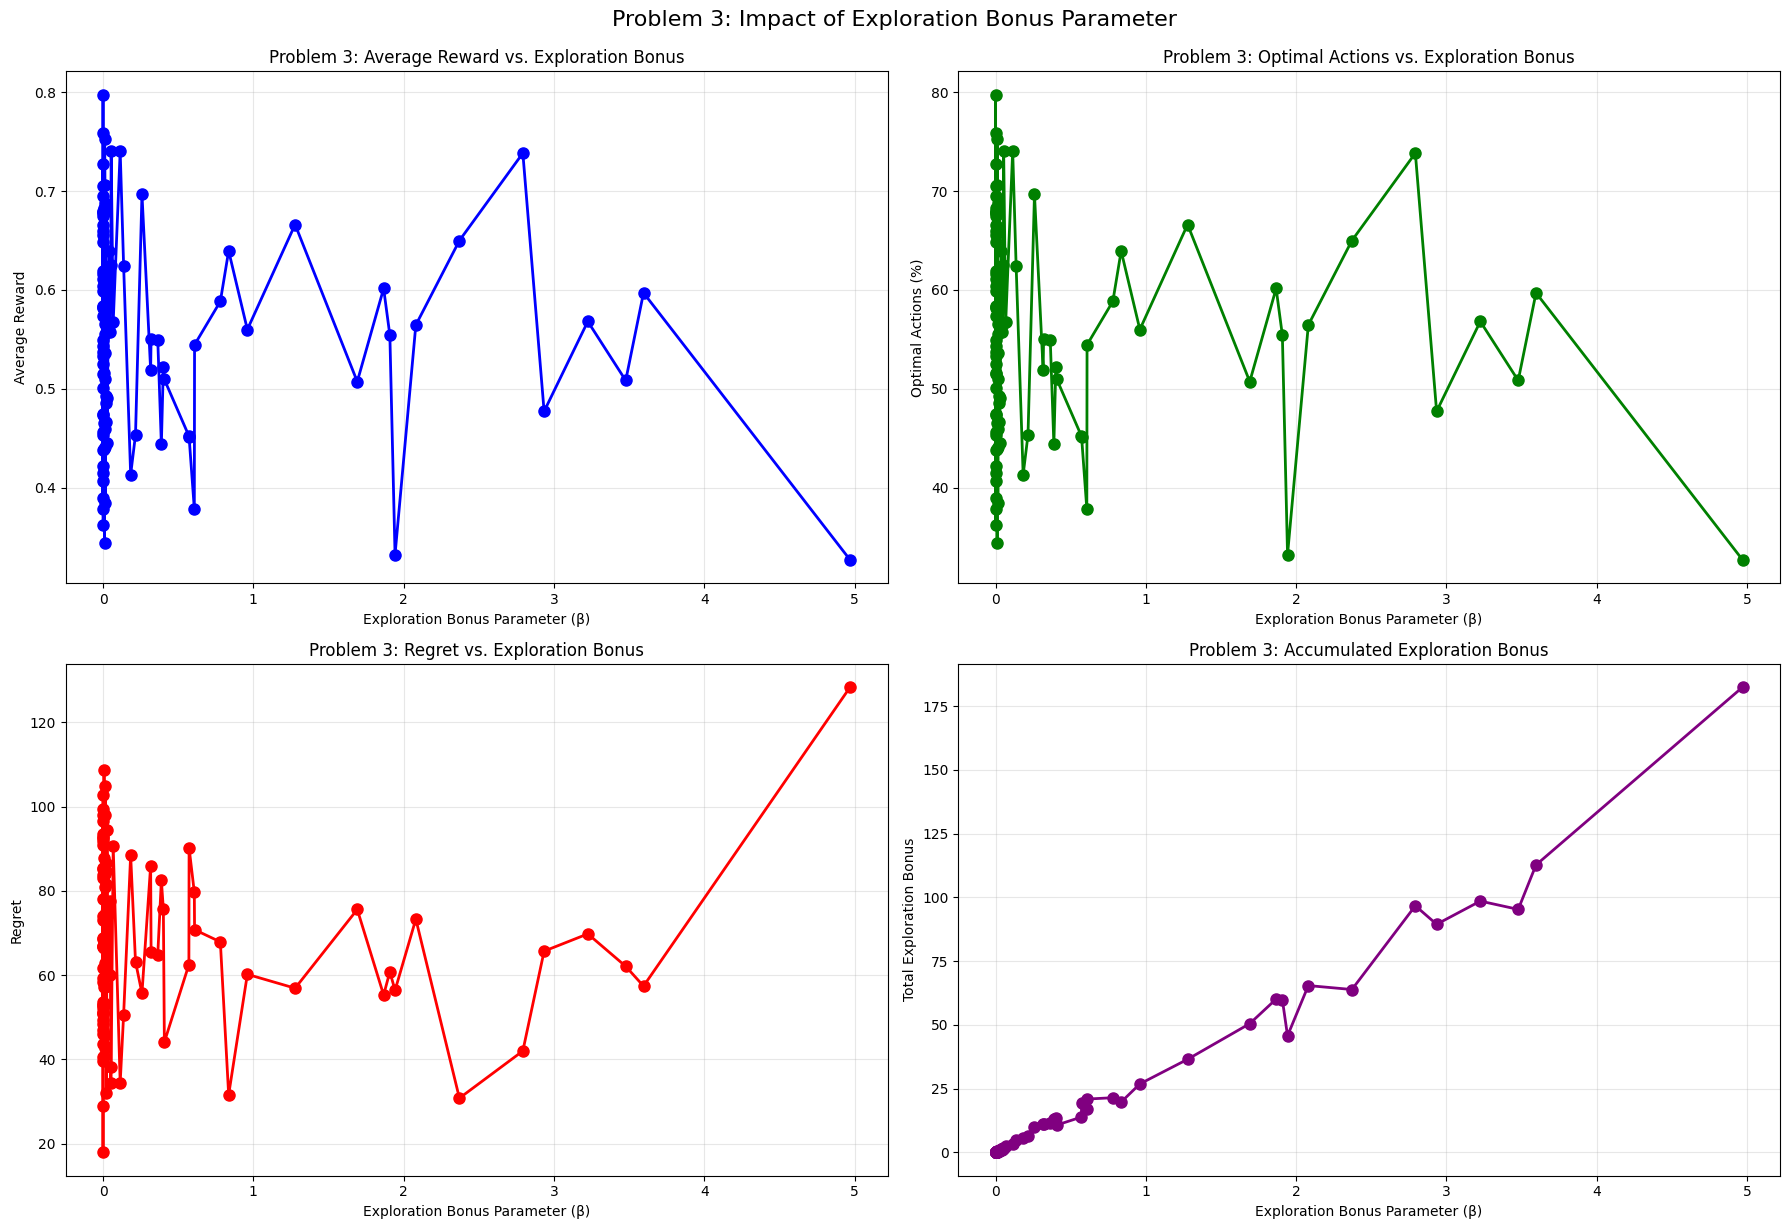

/var/folders/1_/0gj_v5x54fxd8gllt64jsbp80000gn/T/ipykernel_90813/2100408109.py:1836: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=labels, patch_artist=True)


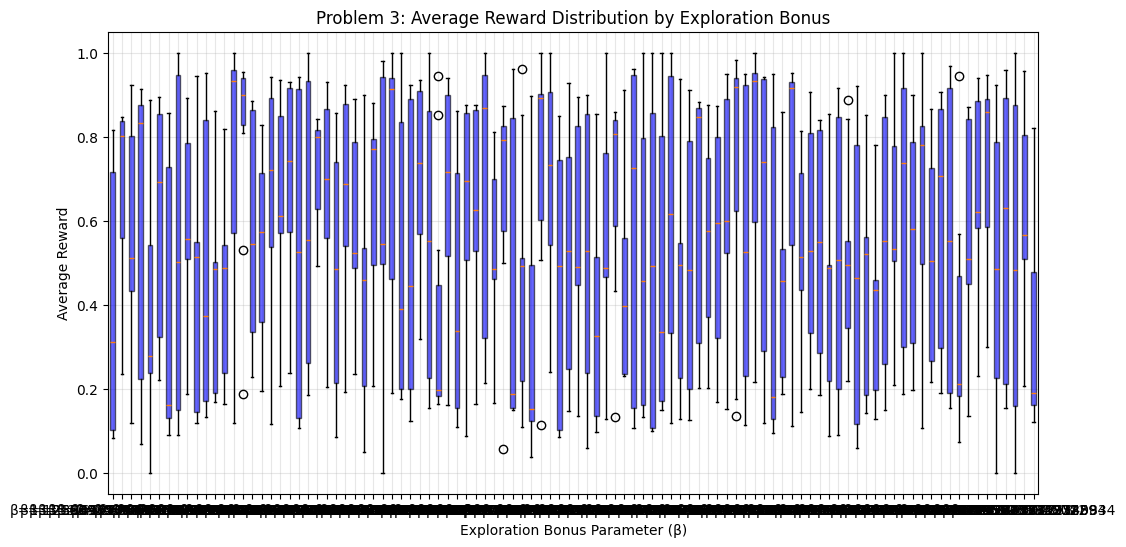

/var/folders/1_/0gj_v5x54fxd8gllt64jsbp80000gn/T/ipykernel_90813/2100408109.py:1836: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=labels, patch_artist=True)


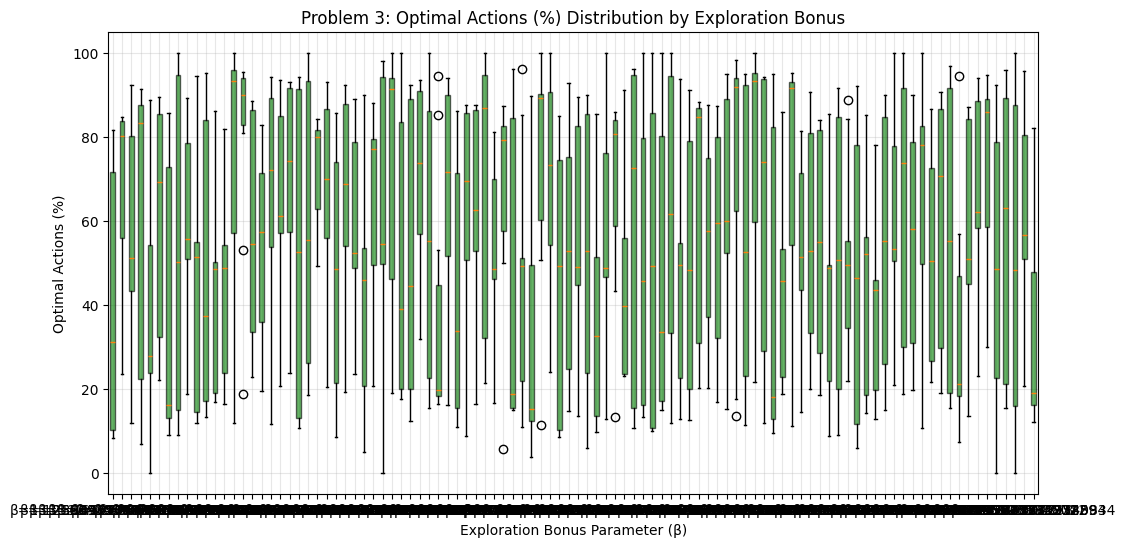

/var/folders/1_/0gj_v5x54fxd8gllt64jsbp80000gn/T/ipykernel_90813/2100408109.py:1836: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=labels, patch_artist=True)


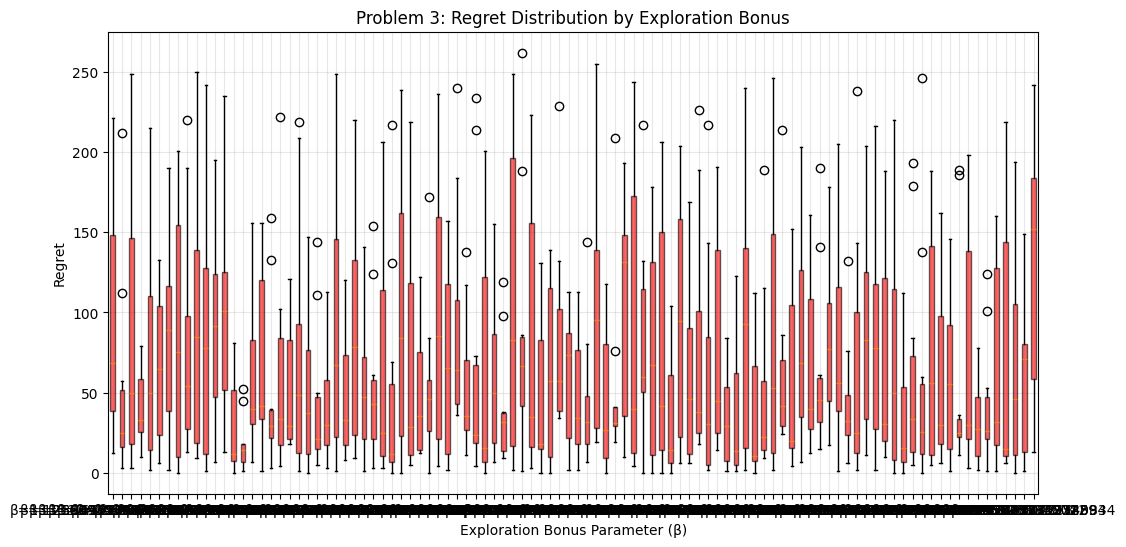


Problem 3: Summary Table of Metrics by Exploration Bonus
    Exploration Bonus (β)  Average Reward  Optimal Actions (%)  Regret  \
0                  0.0000          0.3890              38.9007    93.5   
1                  0.0000          0.6654              66.5382    51.1   
2                  0.0000          0.5436              54.3570    91.9   
3                  0.0000          0.5993              59.9339    40.5   
4                  0.0000          0.4067              40.6710    73.1   
..                    ...             ...                  ...     ...   
95                 2.9344          0.4771              47.7134    65.7   
96                 3.2251          0.5681              56.8117    69.8   
97                 3.4772          0.5084              50.8365    62.1   
98                 3.5957          0.5970              59.7049    57.4   
99                 4.9703          0.3268              32.6774   128.4   

    Total Exploration Bonus  
0                    0.

In [69]:
bonus_values = sample_regularization_lambdas(n=100,low=1e-5,high=5)
a = evaluate_problem3_with_varying_bonus(bonus_values=bonus_values, fixed_turns=False, n_experiments=10)

## Agente 4

In [15]:
def problem4_agent(env_info: Dict) -> int:
    """
    Agent for Problem 4: Partially Observable / Possibly Unknown / Possibly Random T
    """
    # Inicialización de parámetros bayesianos
    if 'prior_counts' not in env_info:
        # Inicializar conteos para la inferencia bayesiana
        # Para cada brazo y cada estado, mantenemos conteos de transiciones
        env_info['prior_counts'] = {
            'arm1': np.ones((2, 2)),  # Conteos para brazo 1 [de estado][a estado]
            'arm2': np.ones((2, 2))   # Conteos para brazo 2 [de estado][a estado]
        }
        # Inicializar creencias sobre estados
        env_info['belief_states'] = {
            'arm1': np.array([0.5, 0.5]),
            'arm2': np.array([0.5, 0.5])
        }
        # Inicializar historial de observaciones
        env_info['observations'] = {
            'arm1': [],
            'arm2': []
        }
    
    # Función para actualizar la inferencia bayesiana
    def update_bayesian_inference(arm, last_state, current_state):
        env_info['prior_counts'][arm][last_state, current_state] += 1
    
    # Función para muestrear matrices de transición
    def sample_transition_matrix(arm):
        counts = env_info['prior_counts'][arm]
        # Muestrear de la distribución Dirichlet para cada fila
        sampled_matrix = np.zeros((2, 2))
        for i in range(2):
            sampled_matrix[i] = np.random.dirichlet(counts[i])
        return sampled_matrix
    
    # Si no es el primer turno, actualizar inferencia
    if env_info['current_turn'] > 0:
        last_action = env_info['history']['actions'][-1]
        last_reward = env_info['history']['rewards'][-1]
        arm = 'arm1' if last_action == 0 else 'arm2'
        
        # Inferir estado actual basado en la recompensa
        current_state = 1 if last_reward > 0.5 else 0  # 1 para bueno, 0 para malo
        
        # Actualizar observaciones
        env_info['observations'][arm].append(current_state)
        
        # Si tenemos suficientes observaciones, actualizar inferencia
        if len(env_info['observations'][arm]) >= 2:
            last_state = env_info['observations'][arm][-2]
            update_bayesian_inference(arm, last_state, current_state)
    
    # Thompson Sampling para selección de brazo
    def thompson_sample(arm):
        # Muestrear matriz de transición
        transition_matrix = sample_transition_matrix(arm)
        
        # Muestrear estado actual
        current_state = np.random.choice(2, p=env_info['belief_states'][arm])
        
        # Muestrear siguiente estado
        next_state = np.random.choice(2, p=transition_matrix[current_state])
        
        # Calcular recompensa esperada
        return 0.8 if next_state == 1 else 0.2
    
    # Muestrear recompensas esperadas para ambos brazos
    arm1_sample = thompson_sample('arm1')
    arm2_sample = thompson_sample('arm2')
    
    # Seleccionar brazo con mayor recompensa muestreada
    return 0 if arm1_sample > arm2_sample else 1

### Turnos Fijos

In [ ]:
a = evaluate_problem4_agent(fixed_turns=True, exploration_bonus=.1, n_experiments=150)

### Turnos no fijos

In [ ]:
a = evaluate_problem4_agent(fixed_turns=False, exploration_bonus=.1, n_experiments=150)

#### Grid para variar bonus de exploración

In [ ]:
bonus_values = sample_regularization_lambdas(n=100,low=1e-5,high=5)
a = evaluate_problem4_with_varying_bonus(bonus_values=bonus_values, fixed_turns=False, n_experiments=10)

# Extra

In [19]:
#all_results = run_all_agents()

In [20]:
#run_all_agents_with_varying_bonus()